В цьому ноутбуці ми проведемо дослідницький аналіз даних про історичні платежі по кредитам клієнтами.

[Опис колонок в даних тут.](https://drive.google.com/file/d/1Yp2aOdC33QFAVfTyxav_gKGwi4M9VN1Z/view?usp=sharing)

Цільова змінна TARGET тут має наступне значення: 1 – клієнт із труднощами з оплатою: він/вона прострочив платіж понад X днів принаймні одного з перших Y платежів кредиту в нашій вибірці, 0 – усі інші випадки

Задача - виявити, яким клієнтам видавати кредит, а яким - не варто, бо вони з високою імовірністю його не повернуть.

Дані взяті з [Kaggle](https://www.kaggle.com/datasets/gauravduttakiit/loan-defaulter). Прошу використовувати саме ті, які надані в нашому курсі, аби нам бути впевненими, що ми точно працюємо з одними і тими ж даними.

<span style="background-color: #f60">IMPORTANT NOTE:</span><br/>
***This workbook is a copy of the notebook provided on ML for people course. Search for custom logic by "Custom logic:" string***

# Імпорт необхідних бібліотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max.rows',130)
pd.set_option('display.max.columns',130)
pd.set_option('float_format', '{:.2f}'.format)

# Імпорт даних

Вмонтуємо наш диск, якщо Ви працюєте в Google Colab. Якщо працюєте локально, пропустіть наступну клітинку.

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

**Custom logic: 1** - download files from remote google drive to local folders

In [2]:
# run to download files from google drive (if not yet downloaded)
from mlpeople.io.google_drive import download_file_public

google_drive_files = [
    {
        'id': '1c8NEH0Bo38lqSh-0eqQ-IXDnbfjd5GQy',
        'name': 'previous_application.csv.zip'
    },
    {
        'id': '1X3lg5Id_JTeQSZRMFWTQeN7ctpV1O2US',
        'name': 'application_data.csv.zip'
    },
    {
        'id': '1yAVnt1tVykvQp0xjzO9gyytNGTzfMlkW',
        'name': 'application_data_processed.zip'
    },
    {
        'id': '1RuSpAVMaDvcc03aHIdczmzCgrd20Q8hy',
        'name': 'columns_description.csv'
    }
]

for file in google_drive_files:
    download_file_public(file['id'], 'downloads/' + file['name'], chunk_size=(1024*512))

Знайдемо, де лежать наші файли з даними. В мене вони знаходяться тут:

In [4]:
# !ls 'drive/MyDrive/Machine Learning для людей/data/credit'
!ls ./downloads

application_data.csv.zip       columns_description.csv
application_data_processed.zip previous_application.csv.zip


Якщо треба зчитати опис, то робимо це аналогічно.

In [6]:
descr = pd.read_csv("downloads/columns_description.csv")

In [7]:
descr.loc[1].Description

'Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)'

Зчитуємо дані.

In [8]:
df = pd.read_csv("downloads/application_data.csv.zip")

In [9]:
# Огляд декількох записів з датафрейму
df.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0         202500.00   406597.50     24700.50   
1               N             0         270000.00  1293502.50     35698.50   
2               Y             0          67500.00   135000.00      6750.00   
3               Y             0         135000.00   312682.50     29686.50   
4               Y             0         121500.00   513000.00     21865.50   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0        351000.00   Unaccompanied          Working   
1       1129500.00          Family    State servant   
2        135000.00   Unaccompanied          Working   
3        297000.00   Unaccompanied          Working   
4        513000.00   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                        0.02       -9461           -637           -3648.00   
1                        0.00      -16765          -1188           -1186.00   
2                        0.01      -19046           -225           -4260.00   
3                        0.01      -19005          -3039           -9833.00   
4                        0.03      -19932          -3038           -4311.00   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531        26.00           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers             1.00   
1                 1           1           0      Core staff             2.00   
2                 1           1           0        Laborers             1.00   
3                 1           0           0        Laborers             2.00   
4                 1           0           0      Core staff             1.00   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

# Перевірка структури даних

In [10]:
df.info(verbose = True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Non-Null Count   Dtype  
---   ------                        --------------   -----  
 0    SK_ID_CURR                    307511 non-null  int64  
 1    TARGET                        307511 non-null  int64  
 2    NAME_CONTRACT_TYPE            307511 non-null  object 
 3    CODE_GENDER                   307511 non-null  object 
 4    FLAG_OWN_CAR                  307511 non-null  object 
 5    FLAG_OWN_REALTY               307511 non-null  object 
 6    CNT_CHILDREN                  307511 non-null  int64  
 7    AMT_INCOME_TOTAL              307511 non-null  float64
 8    AMT_CREDIT                    307511 non-null  float64
 9    AMT_ANNUITY                   307499 non-null  float64
 10   AMT_GOODS_PRICE               307233 non-null  float64
 11   NAME_TYPE_SUITE               306219 non-null  object 
 12   NAME_INCOME_TYPE            

In [11]:
df.shape

(307511, 122)

Маємо ~307k рядків та 122 колонки.

## Статистичний звіт для числових змінних

In [12]:
df.describe()

SK_ID_CURR    TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
count   307511.00 307511.00     307511.00         307511.00   307511.00   
mean    278180.52      0.08          0.42         168797.92   599026.00   
std     102790.18      0.27          0.72         237123.15   402490.78   
min     100002.00      0.00          0.00          25650.00    45000.00   
25%     189145.50      0.00          0.00         112500.00   270000.00   
50%     278202.00      0.00          0.00         147150.00   513531.00   
75%     367142.50      0.00          1.00         202500.00   808650.00   
max     456255.00      1.00         19.00      117000000.00  4050000.00   

       AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
count    307499.00        307233.00                   307511.00   307511.00   
mean      27108.57        538396.21                        0.02   -16037.00   
std       14493.74        369446.46                        0.01     4363.99   
min        1615.50         40500.00                        0.00   -25229.00   
25%       16524.00        238500.00                        0.01   -19682.00   
50%       24903.00        450000.00                        0.02   -15750.00   
75%       34596.00        679500.00                        0.03   -12413.00   
max      258025.50       4050000.00                        0.07    -7489.00   

       DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
count      307511.00          307511.00        307511.00    104582.00   
mean        63815.05           -4986.12         -2994.20        12.06   
std        141275.77            3522.89          1509.45        11.94   
min        -17912.00          -24672.00         -7197.00         0.00   
25%         -2760.00           -7479.50         -4299.00         5.00   
50%         -1213.00           -4504.00         -3254.00         9.00   
75%          -289.00           -2010.00         -1720.00        15.00   
max        365243.00               0.00             0.00        91.00   

       FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  \
count   307511.00       307511.00        307511.00         307511.00   
mean         1.00            0.82             0.20              1.00   
std          0.00            0.38             0.40              0.04   
min          0.00            0.00             0.00              0.00   
25%          1.00            1.00             0.00              1.00   
50%          1.00            1.00             0.00              1.00   
75%          1.00            1.00             0.00              1.00   
max          1.00            1.00             1.00              1.00   

       FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
count   307511.00   307511.00        307509.00             307511.00   
mean         0.28        0.06             2.15                  2.05   
std          0.45        0.23             0.91                  0.51   
min          0.00        0.00             1.00                  1.00   
25%          0.00        0.00             2.00                  2.00   
50%          0.00        0.00             2.00                  2.00   
75%          1.00        0.00             3.00                  2.00   
max          1.00        1.00            20.00                  3.00   

       REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
count                    307511.00                307511.00   
mean                          2.03                    12.06   
std                           0.50                     3.27   
min                           1.00                     0.00   
25%                           2.00                    10.00   
50%                           2.00                    12.00   
75%                           2.00                    14.00   
max                           3.00                    23.00   

       REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
count                   307511

# Аналіз категоріальних змінних

In [13]:
df.select_dtypes(include = "object").columns

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')

In [14]:
# Перевірка кількості категоріальних змінних
len(df.select_dtypes(include = "object").columns)

16

Дані містять 16 `categorical` змінних

# Аналіз числових змінних

In [15]:
number_df = df.select_dtypes(include="number")

In [16]:
number_df.columns

Index(['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=106)

In [17]:
# Перевірка кількості числових змінних
len(number_df.columns)

106

Дані міятять 106 `numerical` змінних

In [18]:
number_df.head()

SK_ID_CURR  TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0      100002       1             0         202500.00   406597.50   
1      100003       0             0         270000.00  1293502.50   
2      100004       0             0          67500.00   135000.00   
3      100006       0             0         135000.00   312682.50   
4      100007       0             0         121500.00   513000.00   

   AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0     24700.50        351000.00                        0.02       -9461   
1     35698.50       1129500.00                        0.00      -16765   
2      6750.00        135000.00                        0.01      -19046   
3     29686.50        297000.00                        0.01      -19005   
4     21865.50        513000.00                        0.03      -19932   

   DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
0           -637           -3648.00            -2120          NaN           1   
1          -1188           -1186.00             -291          NaN           1   
2           -225           -4260.00            -2531        26.00           1   
3          -3039           -9833.00            -2437          NaN           1   
4          -3038           -4311.00            -3458          NaN           1   

   FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
0               1                0                 1           1           0   
1               1                0                 1           1           0   
2               1                1                 1           1           0   
3               1                0                 1           0           0   
4               1                0                 1           0           0   

   CNT_FAM_MEMBERS  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0             1.00                     2                            2   
1             2.00                     1                            1   
2             1.00                     2                            2   
3             2.00                     2                            2   
4             1.00                     2                            2   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                       10                           0   
1                       11                           0   
2                        9                           0   
3                       17                           0   
4                       11                           0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                           0                            0   
1                           0                            0   
2                           0                            0   
3                           0                            0   
4                           0                            0   

   REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  \
0                       0                       0                        0   
1                       0                       0                        0   
2                       0                       0                        0   
3                       0                       0                        0   
4                       0                       1                        1   

   EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0          0.08          0.26          0.14            0.02              0.04   
1          0.31          0.62           NaN            0.10              0.05   
2           NaN          0.56          0.73             NaN               NaN   
3           NaN          0.65           NaN             NaN               NaN   
4           NaN          0.32           NaN             NaN               NaN   

   YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  COM

# Робота з некоректними типами даних

Перевірка, чи немає у нас стовпця з неправильним типом даних

In [19]:
df.dtypes

SK_ID_CURR                        int64
TARGET                            int64
NAME_CONTRACT_TYPE               object
CODE_GENDER                      object
FLAG_OWN_CAR                     object
FLAG_OWN_REALTY                  object
CNT_CHILDREN                      int64
AMT_INCOME_TOTAL                float64
AMT_CREDIT                      float64
AMT_ANNUITY                     float64
AMT_GOODS_PRICE                 float64
NAME_TYPE_SUITE                  object
NAME_INCOME_TYPE                 object
NAME_EDUCATION_TYPE              object
NAME_FAMILY_STATUS               object
NAME_HOUSING_TYPE                object
REGION_POPULATION_RELATIVE      float64
DAYS_BIRTH                        int64
DAYS_EMPLOYED                     int64
DAYS_REGISTRATION               float64
DAYS_ID_PUBLISH                   int64
OWN_CAR_AGE                     float64
FLAG_MOBIL                        int64
FLAG_EMP_PHONE                    int64
FLAG_WORK_PHONE                   int64


Дивлячись на дані та відповідні їм типи даних, можна змінити тип стовпчика SKU.

In [20]:
df['SK_ID_CURR'] = df['SK_ID_CURR'].astype("str")

Також ми можемо змінити всі стовпці `flag` на тип даних, який є більш економний для зберігання.

Ось скільки пам'яті в Мб займають наші дані зараз.

In [21]:
df.memory_usage().sum()/1024/1024

np.float64(286.22710037231445)

In [22]:
'flag' in 'SK_ID_CURR'.lower()

False

In [23]:
flag_cols = ['flag' in col.lower() for col in df.columns]

In [24]:
df[df.columns[flag_cols]].head()

FLAG_OWN_CAR FLAG_OWN_REALTY  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            N               Y           1               1                0   
1            N               N           1               1                0   
2            Y               Y           1               1                1   
3            N               Y           1               1                0   
4            N               Y           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  FLAG_DOCUMENT_2  FLAG_DOCUMENT_3  \
0                 1           1           0                0                1   
1                 1           1           0                0                1   
2                 1           1           0                0                0   
3                 1           0           0                0                1   
4                 1           0           0                0                0   

   FLAG_DOCUMENT_4  FLAG_DOCUMENT_5  FLAG_DOCUMENT_6  FLAG_DOCUMENT_7  \
0                0                0                0                0   
1                0                0                0                0   
2                0                0                0                0   
3                0                0                0                0   
4                0                0                0                0   

   FLAG_DOCUMENT_8  FLAG_DOCUMENT_9  FLAG_DOCUMENT_10  FLAG_DOCUMENT_11  \
0                0                0                 0                 0   
1                0                0                 0                 0   
2                0                0                 0                 0   
3                0                0                 0                 0   
4                1                0                 0                 0   

   FLAG_DOCUMENT_12  FLAG_DOCUMENT_13  FLAG_DOCUMENT_14  FLAG_DOCUMENT_15  \
0                 0                 0                 0                 0   
1                 0                 0                 0                 0   
2                 0                 0                 0                 0   
3                 0                 0                 0                 0   
4                 0                 0                 0                 0   

   FLAG_DOCUMENT_16  FLAG_DOCUMENT_17  FLAG_DOCUMENT_18  FLAG_DOCUMENT_19  \
0                 0                 0                 0                 0   
1                 0                 0                 0                 0   
2                 0                 0                 0                 0   
3                 0                 0                 0                 0   
4                 0                 0                 0                 0   

   FLAG_DOCUMENT_20  FLAG_DOCUMENT_21  
0                 0                 0  
1                 0                 0  
2                 0                 0  
3                 0                 0  
4                 0                 0

In [25]:
df[df.columns[flag_cols]].nunique()

FLAG_OWN_CAR        2
FLAG_OWN_REALTY     2
FLAG_MOBIL          2
FLAG_EMP_PHONE      2
FLAG_WORK_PHONE     2
FLAG_CONT_MOBILE    2
FLAG_PHONE          2
FLAG_EMAIL          2
FLAG_DOCUMENT_2     2
FLAG_DOCUMENT_3     2
FLAG_DOCUMENT_4     2
FLAG_DOCUMENT_5     2
FLAG_DOCUMENT_6     2
FLAG_DOCUMENT_7     2
FLAG_DOCUMENT_8     2
FLAG_DOCUMENT_9     2
FLAG_DOCUMENT_10    2
FLAG_DOCUMENT_11    2
FLAG_DOCUMENT_12    2
FLAG_DOCUMENT_13    2
FLAG_DOCUMENT_14    2
FLAG_DOCUMENT_15    2
FLAG_DOCUMENT_16    2
FLAG_DOCUMENT_17    2
FLAG_DOCUMENT_18    2
FLAG_DOCUMENT_19    2
FLAG_DOCUMENT_20    2
FLAG_DOCUMENT_21    2
dtype: int64

Типи даних в pandas взяті з numpy, і ось тут список всіх типів даних в numpy:

https://numpy.org/doc/stable/user/basics.types.html

Кожен тип даних займає певну кількість байт у пам'яті. Давайте з'ясуємо, скільки займає 1 тип int8 та 1 тип int64 і скільки пам'яті ми заощадимо, якщо змінимо тип.

In [26]:
import numpy as np
from sys import getsizeof

In [27]:
getsizeof(np.int64(1))

32

In [28]:
getsizeof(np.int8(1))

25

In [29]:
7 * df.shape[0] * sum(flag_cols) / 1024 / 1024

57.48000717163086

Отже, ми можемо потенційно заощадити 57 Мб пам'яті! І трансформувати наш фрейм даних буде простіше. Давайте змінимо тип.


In [30]:
str_flag_cols = ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY']

In [31]:
for col in str_flag_cols:
  df[col] = np.where(df[col]=='Y', 1, 0)

In [32]:
df[str_flag_cols].nunique()

FLAG_OWN_CAR       2
FLAG_OWN_REALTY    2
dtype: int64

In [33]:
df.columns[flag_cols]

Index(['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_MOBIL', 'FLAG_EMP_PHONE',
       'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4',
       'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7',
       'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10',
       'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13',
       'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16',
       'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19',
       'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21'],
      dtype='object')

In [34]:
df[df.columns[flag_cols]] = df[df.columns[flag_cols]].astype('int8')

In [35]:
df.memory_usage().sum()/1024/1024

np.float64(228.7470932006836)

**Custom logic: 2** - try do the same as above - optimize memory usage for boolean flag columns

In [36]:
import pandas as pd
import numpy as np
from mlpeople.optimization import get_all_bool_flag_cols, optimize_bool_flag_cols

In [37]:
df = pd.read_csv("./downloads/application_data.csv.zip")
df.memory_usage().sum()/1024/1024

np.float64(286.22710037231445)

In [38]:
df = optimize_bool_flag_cols(df, get_all_bool_flag_cols(df))
df.memory_usage().sum()/1024/1024

np.float64(218.4828062057495)

# Робота з пропущеними значеннями

Найпростіше емпіричне правило для опрацювання пропущених значень: якщо пропущених значень більше за 40% - видаляємо колонку, якщо менше за 40% - аналізуємо, як можна заповнити і чи треба.

Зазвичай, якщо відсоток пропущених даних більший за 10 і немає чіткої (яка значно виділяється) моди (найчастішого) значення в даних, то лишаємо дані як є до використання методів машинного навчання. Далі якщо метод вимагає заповення пропущених значень, можемо експериментувати із заповеннями. Також хорошою практикою є створити окрему колонку-флаг (0/1), яка вказує, де були пропущені значення - це буде додаткова ознака для моделі.


Перевіримо, чи немає null-значень в нашому наборі даних

In [39]:
df.isnull().values.any()

np.True_

Порахуємо загальну кількість null-значень в наборі даних

In [40]:
df.isnull().values.sum()

np.int64(9152465)

Сформуємо список із стовпців з null-значеннями

In [41]:
df.columns[df.isnull().any()]

Index(['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'OWN_CAR_AGE',
       'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG',
       'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG',
       'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG',
       'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG',
       'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE',
       'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE',
       'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE',
       'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE',
       'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE',
       'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI',
       'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI',
       'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMI

In [42]:
len(df.columns[df.isnull().any()])

67

Усього `67` стовпців мають одне або більше NULL-значень в даних

## Кількість та відсоток пропущених значень у стовпцях

In [43]:
null_count = df.isnull().sum()
null_percentage = round((df.isnull().sum()/df.shape[0])*100, 2)

In [44]:
df.shape[0]

307511

In [45]:
null_df = pd.DataFrame({'column_name' : df.columns,'null_count' : null_count,'null_percentage': null_percentage})
null_df.reset_index(drop = True, inplace = True)

In [46]:
null_df.sort_values(by = 'null_percentage', ascending = False)

column_name  null_count  null_percentage
76                COMMONAREA_MEDI      214865            69.87
48                 COMMONAREA_AVG      214865            69.87
62                COMMONAREA_MODE      214865            69.87
70       NONLIVINGAPARTMENTS_MODE      213514            69.43
56        NONLIVINGAPARTMENTS_AVG      213514            69.43
84       NONLIVINGAPARTMENTS_MEDI      213514            69.43
86             FONDKAPREMONT_MODE      210295            68.39
68          LIVINGAPARTMENTS_MODE      210199            68.35
54           LIVINGAPARTMENTS_AVG      210199            68.35
82          LIVINGAPARTMENTS_MEDI      210199            68.35
52                  FLOORSMIN_AVG      208642            67.85
66                 FLOORSMIN_MODE      208642            67.85
80                 FLOORSMIN_MEDI      208642            67.85
75               YEARS_BUILD_MEDI      204488            66.50
61               YEARS_BUILD_MODE      204488            66.50
47                YEARS_BUILD_AVG      204488            66.50
21                    OWN_CAR_AGE      202929            65.99
81                  LANDAREA_MEDI      182590            59.38
67                  LANDAREA_MODE      182590            59.38
53                   LANDAREA_AVG      182590            59.38
73              BASEMENTAREA_MEDI      179943            58.52
45               BASEMENTAREA_AVG      179943            58.52
59              BASEMENTAREA_MODE      179943            58.52
41                   EXT_SOURCE_1      173378            56.38
71             NONLIVINGAREA_MODE      169682            55.18
57              NONLIVINGAREA_AVG      169682            55.18
85             NONLIVINGAREA_MEDI      169682            55.18
77                 ELEVATORS_MEDI      163891            53.30
49                  ELEVATORS_AVG      163891            53.30
63                 ELEVATORS_MODE      163891            53.30
89             WALLSMATERIAL_MODE      156341            50.84
72                APARTMENTS_MEDI      156061            50.75
44                 APARTMENTS_AVG      156061            50.75
58                APARTMENTS_MODE      156061            50.75
78                 ENTRANCES_MEDI      154828            50.35
50                  ENTRANCES_AVG      154828            50.35
64                 ENTRANCES_MODE      154828            50.35
55                 LIVINGAREA_AVG      154350            50.19
69                LIVINGAREA_MODE      154350            50.19
83                LIVINGAREA_MEDI      154350            50.19
87                 HOUSETYPE_MODE      154297            50.18
65                 FLOORSMAX_MODE      153020            49.76
79                 FLOORSMAX_MEDI      153020            49.76
51                  FLOORSMAX_AVG      153020            49.76
60   YEARS_BEGINEXPLUATATION_MODE      150007            48.78
74   YEARS_BEGINEXPLUATATION_MEDI      150007            48.78
46    YEARS_BEGINEXPLUATATION_AVG      150007            48.78
88                 TOTALAREA_MODE      148431            48.27
90            EMERGENCYSTATE_MODE      145755            47.40
28                OCCUPATION_TYPE       96391            31.35
43                   EXT_SOURCE_3       60965            19.83
116    AMT_REQ_CREDIT_BUREAU_HOUR       41519            13.50
117     AMT_REQ_CREDIT_BUREAU_DAY       41519            13.50
118    AMT_REQ_CREDIT_BUREAU_WEEK       41519            13.50
119     AMT_REQ_CREDIT_BUREAU_MON       41519            13.50
120     AMT_REQ_CREDIT_BUREAU_QRT       41519            13.50
121    AMT_REQ_CREDIT_BUREAU_YEAR       41519            13.50
11                NAME_TYPE_SUITE        1292             0.42
92       DEF_30_CNT_SOCIAL_CIRCLE        1021             0.33
91       OBS_30_CNT_SOCIAL_CIRCLE        1021             0.33
93       OBS_60_CNT_SOCIAL_CIRCLE        1021             0.33
94       DEF_60_CNT_SOCIAL_CIRCLE        1021             0.33
42                   EXT_SOURCE_2         660        

## Видалення стовпців з NULL значеннями > 40%

Сформуємо список стовпців з NULL значеннями > 40% у список. Ми видалимо ці стовпці з датафрейму, оскільки в них занадто багато пропущених значень.

In [47]:
columns_to_be_deleted = null_df[null_df['null_percentage'] > 40].column_name.to_list()

In [48]:
len(columns_to_be_deleted)

49

Всього потрібно видалити `49` стовпців. Видалення їх з основного датафрейму **`df`**

In [49]:
df.drop(columns = columns_to_be_deleted, inplace = True)

Перевірка підрахунку стовпців після видалення. Мало б залишитись лише `73` стовпці

In [50]:
df.shape

(307511, 73)

**Custom logic: 3** - move some missing values handling logic to separate methods and python file

In [53]:
from mlpeople.eda.missing import (
    get_null_df,
    drop_cols_above_missing_threshold,
    show_cols_below_missing_threshold,
    show_cols_above_missing_threshold,
)

In [54]:
get_null_df(df).head()

column_name  null_count  null_percentage
27             OCCUPATION_TYPE       96391            31.35
41                EXT_SOURCE_3       60965            19.83
72  AMT_REQ_CREDIT_BUREAU_YEAR       41519            13.50
71   AMT_REQ_CREDIT_BUREAU_QRT       41519            13.50
70   AMT_REQ_CREDIT_BUREAU_MON       41519            13.50

In [56]:
show_cols_below_missing_threshold(df, 30).head()

column_name  null_count  null_percentage
41                EXT_SOURCE_3       60965            19.83
72  AMT_REQ_CREDIT_BUREAU_YEAR       41519            13.50
71   AMT_REQ_CREDIT_BUREAU_QRT       41519            13.50
70   AMT_REQ_CREDIT_BUREAU_MON       41519            13.50
69  AMT_REQ_CREDIT_BUREAU_WEEK       41519            13.50

In [57]:
show_cols_above_missing_threshold(df, 30).head()

column_name  null_count  null_percentage
27  OCCUPATION_TYPE       96391            31.35

## Перевірка стовпців з NULL значеннями < 40%

Створення датафрейму `null_df_under40` зі стовпцями, де відсоток пропущених значеннь менше 40%

In [58]:
null_df_under40 = null_df[null_df['null_percentage'] < 40]

In [59]:
null_df_under40.sort_values(by = 'null_percentage', ascending = False)

column_name  null_count  null_percentage
28               OCCUPATION_TYPE       96391            31.35
43                  EXT_SOURCE_3       60965            19.83
121   AMT_REQ_CREDIT_BUREAU_YEAR       41519            13.50
120    AMT_REQ_CREDIT_BUREAU_QRT       41519            13.50
119    AMT_REQ_CREDIT_BUREAU_MON       41519            13.50
118   AMT_REQ_CREDIT_BUREAU_WEEK       41519            13.50
117    AMT_REQ_CREDIT_BUREAU_DAY       41519            13.50
116   AMT_REQ_CREDIT_BUREAU_HOUR       41519            13.50
11               NAME_TYPE_SUITE        1292             0.42
91      OBS_30_CNT_SOCIAL_CIRCLE        1021             0.33
92      DEF_30_CNT_SOCIAL_CIRCLE        1021             0.33
93      OBS_60_CNT_SOCIAL_CIRCLE        1021             0.33
94      DEF_60_CNT_SOCIAL_CIRCLE        1021             0.33
42                  EXT_SOURCE_2         660             0.21
10               AMT_GOODS_PRICE         278             0.09
101              FLAG_DOCUMENT_7           0             0.00
95        DAYS_LAST_PHONE_CHANGE           1             0.00
96               FLAG_DOCUMENT_2           0             0.00
97               FLAG_DOCUMENT_3           0             0.00
98               FLAG_DOCUMENT_4           0             0.00
99               FLAG_DOCUMENT_5           0             0.00
100              FLAG_DOCUMENT_6           0             0.00
105             FLAG_DOCUMENT_11           0             0.00
102              FLAG_DOCUMENT_8           0             0.00
103              FLAG_DOCUMENT_9           0             0.00
104             FLAG_DOCUMENT_10           0             0.00
39       LIVE_CITY_NOT_WORK_CITY           0             0.00
106             FLAG_DOCUMENT_12           0             0.00
107             FLAG_DOCUMENT_13           0             0.00
108             FLAG_DOCUMENT_14           0             0.00
109             FLAG_DOCUMENT_15           0             0.00
110             FLAG_DOCUMENT_16           0             0.00
111             FLAG_DOCUMENT_17           0             0.00
112             FLAG_DOCUMENT_18           0             0.00
113             FLAG_DOCUMENT_19           0             0.00
114             FLAG_DOCUMENT_20           0             0.00
115             FLAG_DOCUMENT_21           0             0.00
40             ORGANIZATION_TYPE           0             0.00
0                     SK_ID_CURR           0             0.00
38        REG_CITY_NOT_WORK_CITY           0             0.00
9                    AMT_ANNUITY          12             0.00
17                    DAYS_BIRTH           0             0.00
16    REGION_POPULATION_RELATIVE           0             0.00
15             NAME_HOUSING_TYPE           0             0.00
14            NAME_FAMILY_STATUS           0             0.00
13           NAME_EDUCATION_TYPE           0             0.00
12              NAME_INCOME_TYPE           0             0.00
8                     AMT_CREDIT           0             0.00
1                         TARGET           0             0.00
7               AMT_INCOME_TOTAL           0             0.00
6                   CNT_CHILDREN           0             0.00
5                FLAG_OWN_REALTY           0             0.00
4                   FLAG_OWN_CAR           0             0.00
3                    CODE_GENDER           0             0.00
2             NAME_CONTRACT_TYPE           0             0.00
18                 DAYS_EMPLOYED           0             0.00
19             DAYS_REGISTRATION           0             0.00
20               DAYS_ID_PUBLISH           0             0.00
22                    FLAG_MOBIL           0             0.00
23                FLAG_EMP_PHONE           0             0.00
24               FLAG_WORK_PHONE           0             0.00
25              FLAG_CONT_MOBILE           0             0.00
26                    FLAG_PHONE           0             0.00
27                    FLAG_EMAIL           0         

Опрацюємо кожну з колонок.

### Аналіз стовпця `OCCUPATION_TYPE`

- нульові значення = 31.35%

In [60]:
df['OCCUPATION_TYPE'].value_counts()

OCCUPATION_TYPE
Laborers                 55186
Sales staff              32102
Core staff               27570
Managers                 21371
Drivers                  18603
High skill tech staff    11380
Accountants               9813
Medicine staff            8537
Security staff            6721
Cooking staff             5946
Cleaning staff            4653
Private service staff     2652
Low-skill Laborers        2093
Waiters/barmen staff      1348
Secretaries               1305
Realty agents              751
HR staff                   563
IT staff                   526
Name: count, dtype: int64

Заміна NULL-значень на категорією `Unknown`

In [ ]:
df['OCCUPATION_TYPE'].fillna(value = 'Unknown', inplace = True)

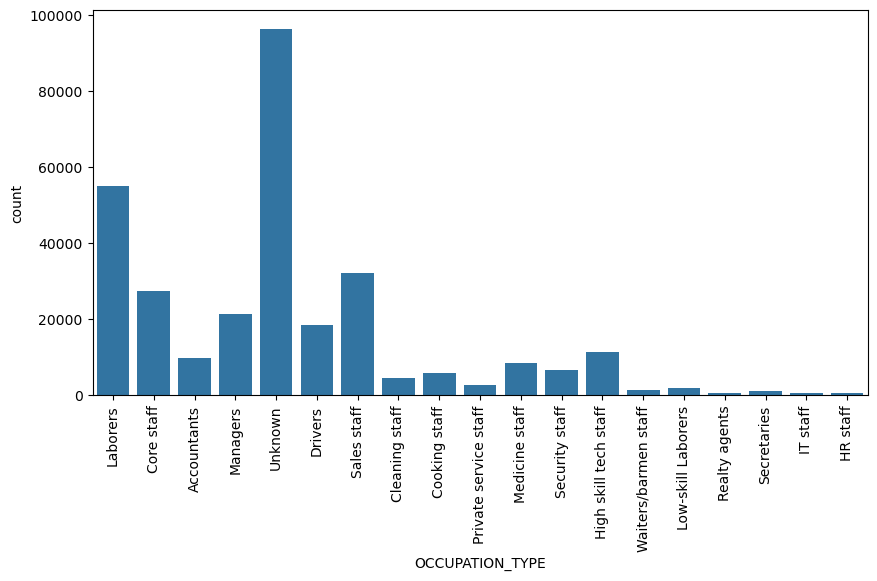

In [62]:
plt.figure(figsize = (10,5))
sns.countplot(data = df, x = "OCCUPATION_TYPE")
plt.xticks(rotation = 90)
plt.show()

**Спостереження**
- Якщо поглянути на графік, то найбільшу кількість заявників на кредит мають `Laborers`
- Для імпутації краще залишити дані як є (пропущені значення становлять 31,35%) і не проводити імпутацію за якоюсь константою, як-от мода або мін/макс медіана, якщо це числовий стовпчик, оскільки це може викривити дані в подальших розрахунках.

Існує також можливість імпутації за допомогою більш "розумних" методів, але ми вивчимо їх пізніше, а зараз ми робимо те, що можемо, за допомогою деяких найпростіших перетворень.

### Аналіз стовпця `EXT_SOURCE_3`

- пропущені значення = 19.83%

In [63]:
df.EXT_SOURCE_3.value_counts().head()

EXT_SOURCE_3
0.75    1460
0.71    1315
0.69    1276
0.67    1191
0.65    1154
Name: count, dtype: int64

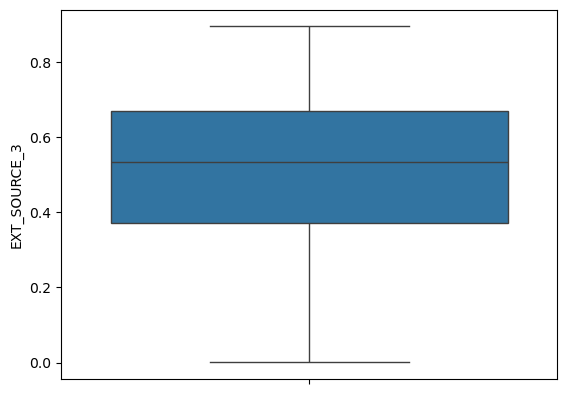

In [64]:
sns.boxplot(df.EXT_SOURCE_3)
plt.show()

Отримання процентильних значень для `EXT_SOURCE_3`

In [65]:
df.EXT_SOURCE_3.quantile(q = [0.25,0.5,0.75,1])

0.25   0.37
0.50   0.54
0.75   0.67
1.00   0.90
Name: EXT_SOURCE_3, dtype: float64

Найбільш повторюване значення в `EXT_SOURCE_3

In [66]:
df.EXT_SOURCE_3.mode()[0]

np.float64(0.746300213050371)

Перевірка середнього значення `EXT_SOURCE_3`

In [67]:
df.EXT_SOURCE_3.mean()

np.float64(0.5108529061799657)

**Спостереження**
-  Дивлячись на діагараму розмаху, медіана становить 0,535276
-  Найчастіше повторюване значення - 0,74630
-  Середнє значення - 0,51085
-  Хоча середнє та медіана є ближчими і можуть бути використані для імпутації, оскільки відсутнє відсоткове значення є більшим (19,83%), краще залишити дані як є і не проводити імпутації. Якщо метод вимагає імпутації, ми можемо імпутувати дані за допомогою медіани і створити ще один стовпчик, в якому буде позначено, які значення були імпутовані.

# Перевірка стовпців зі значеннями NULL > 0% та < 1%

Створення датафрейму `null_df_under1` з відсотком пропущених значень > 0% та < 1% у кожному стовпці

In [68]:
null_df_under1 = null_df[(null_df['null_percentage'] > 0) & (null_df['null_percentage'] < 1)]

In [69]:
null_df_under1.sort_values(by = 'null_percentage', ascending = False)

column_name  null_count  null_percentage
11           NAME_TYPE_SUITE        1292             0.42
91  OBS_30_CNT_SOCIAL_CIRCLE        1021             0.33
92  DEF_30_CNT_SOCIAL_CIRCLE        1021             0.33
93  OBS_60_CNT_SOCIAL_CIRCLE        1021             0.33
94  DEF_60_CNT_SOCIAL_CIRCLE        1021             0.33
42              EXT_SOURCE_2         660             0.21
10           AMT_GOODS_PRICE         278             0.09

## Аналіз стовпця `NAME_TYPE_SUITE`

In [70]:
null_df_under1[null_df_under1.column_name == 'NAME_TYPE_SUITE']

column_name  null_count  null_percentage
11  NAME_TYPE_SUITE        1292             0.42

In [71]:
df['NAME_TYPE_SUITE'].value_counts()

NAME_TYPE_SUITE
Unaccompanied      248526
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
Other_A               866
Group of people       271
Name: count, dtype: int64

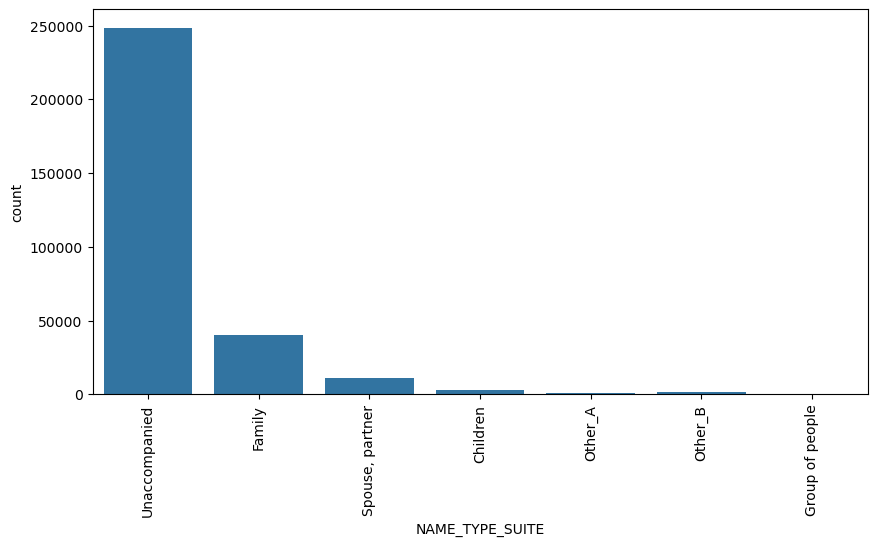

In [72]:
plt.figure(figsize = (10,5))
sns.countplot(data = df, x = "NAME_TYPE_SUITE")
plt.xticks(rotation = 90)
plt.show()

**Спостереження**
-   Дивлячись на графік, категорія `Unaccompanied` має найбільшу кількість заявників на отримання кредиту. Отже, більшість позичальників наважуються звертатися за кредитом без супроводу.
- Ми можемо продовжити імпутацію `Unaccompanied` в датафреймі, але краше надати перевагу другому варіанту.
- Ми також могли б імпутувати дані зі значенням `NA`, оскільки ця колонка є категоричною.
- Аналогічно, якщо в колонці не вистачає менше 1% даних, ми можемо її опустити. Але якщо ми вилучимо всі дані в усіх стовпчиках, де пропущено <=1% даних, ми можемо вилучити занадто багато даних. Тому я здебільшого зберігаю дані настільки, наскільки це можливо.

In [ ]:
df['NAME_TYPE_SUITE'].fillna('NA', inplace=True)

## Аналіз стовпця `OBS_30_CNT_SOCIAL_CIRCLE`

In [74]:
null_df_under1[null_df_under1.column_name == 'OBS_30_CNT_SOCIAL_CIRCLE']

column_name  null_count  null_percentage
91  OBS_30_CNT_SOCIAL_CIRCLE        1021             0.33

In [75]:
df.OBS_30_CNT_SOCIAL_CIRCLE.value_counts().head(10)

OBS_30_CNT_SOCIAL_CIRCLE
0.00    163910
1.00     48783
2.00     29808
3.00     20322
4.00     14143
5.00      9553
6.00      6453
7.00      4390
8.00      2967
9.00      2003
Name: count, dtype: int64

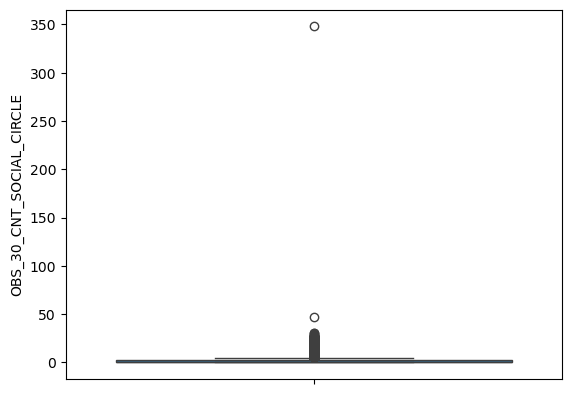

In [76]:
sns.boxplot(df.OBS_30_CNT_SOCIAL_CIRCLE)
plt.show()

Розрахунок перцентилів `OBS_30_CNT_SOCIAL_CIRCLE`

In [77]:
df.OBS_30_CNT_SOCIAL_CIRCLE.quantile(q = [0.25,0.5,0.75,1])

0.25     0.00
0.50     0.00
0.75     2.00
1.00   348.00
Name: OBS_30_CNT_SOCIAL_CIRCLE, dtype: float64

Найбільш повторюване значення в `OBS_30_CNT_SOCIAL_CIRCLE`

In [78]:
df.OBS_30_CNT_SOCIAL_CIRCLE.mode()[0]

np.float64(0.0)

Середнє значення `OBS_30_CNT_SOCIAL_CIRCLE`

In [79]:
df.OBS_30_CNT_SOCIAL_CIRCLE.mean()

np.float64(1.4222454239942575)

**Спостереження**
- Дивлячись на діаграму розмаху, медіана дорівнює 0.0
- Найчастіше повторюване значення - 0.0
- Середнє значення - 1,4222
- Є два викидні значення на рівні 50 та 350.
- Медіана і мода близькі (з огляду на діапазон даних у цьому стовпчику) і можуть бути використані для імпутації. Це не призведе до зміщення, оскільки відсоток пропущених значень невеликий (0,33%)

In [ ]:
df['OBS_30_CNT_SOCIAL_CIRCLE'].fillna(df['OBS_30_CNT_SOCIAL_CIRCLE'].median(), inplace=True)

# Робота з неправильними/невідомими значеннями даних

### Аналіз стовпця `CODE_GENDER`

Перевірка діапазону значень

In [83]:
df['CODE_GENDER'].value_counts()

CODE_GENDER
F      202448
M      105059
XNA         4
Name: count, dtype: int64

Стать має бути тільки чоловіча або жіноча. Значення `XNA` може вказувати на те, що значення не було надано заявником або пропущено кредитним спеціалістом, який перевіряє заявку

In [84]:
df[df['CODE_GENDER'] == 'XNA']

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE CODE_GENDER  FLAG_OWN_CAR  \
35657       141289       0                0.00         XNA          1.00   
38566       144669       0                0.00         XNA          0.00   
83382       196708       0                0.00         XNA          0.00   
189640      319880       0                0.00         XNA          1.00   

        FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
35657              1.00             0         207000.00   382500.00   
38566              1.00             2         157500.00   270000.00   
83382              1.00             1         135000.00   405000.00   
189640             1.00             0         247500.00   540000.00   

        AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
35657      19125.00        337500.00   Unaccompanied               Working   
38566      13500.00        225000.00          Family               Working   
83382      20250.00        225000.00   Unaccompanied               Working   
189640     27000.00        900000.00   Unaccompanied  Commercial associate   

                  NAME_EDUCATION_TYPE NAME_FAMILY_STATUS    NAME_HOUSING_TYPE  \
35657   Secondary / secondary special            Married  Municipal apartment   
38566   Secondary / secondary special            Married    House / apartment   
83382                Higher education            Married    House / apartment   
189640              Incomplete higher     Civil marriage    House / apartment   

        REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
35657                         0.02      -20232         -10044   
38566                         0.03      -13717          -2797   
83382                         0.04      -10647          -1228   
189640                        0.04       -9649          -2293   

        DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  FLAG_EMP_PHONE  \
35657           -10024.00            -3537           1               1   
38566            -2241.00            -4659           1               1   
83382             -183.00            -1671           1               1   
189640           -4099.00            -2326           1               1   

        FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
35657                 1                 1           1           0   
38566                 1                 1           1           0   
83382                 1                 1           1           0   
189640                1                 1           1           0   

           OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
35657              Unknown             2.00                     3   
38566   Low-skill Laborers             4.00                     2   
83382           Core staff             3.00                     2   
189640             Unknown             2.00                     2   

        REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
35657                             3                    TUESDAY   
38566                             2                     FRIDAY   
83382                             2                   THURSDAY   
189640                            2                     FRIDAY   

        HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
35657                        10                           0   
38566                        16                           0   
83382                        15                           0   
189640                       15                           0   

        REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
35657                            0                            0   
38566                            0                            0   
83382                            0                            0   
189640                           0                            0   

        REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  \
35657                        0              

Оскільки дані виглядають достовірними, ми перевіримо можливість застосування методу імпутації.
- Заявників-жінок удвічі більше, ніж заявників-чоловіків
- Отже, ми прирівняємо `CODE_GENDER` до 'F'

In [85]:
df['CODE_GENDER_CHANGED'] = df['CODE_GENDER'].apply(lambda x: 1 if x == 'XNA' else 0)

In [86]:
df['CODE_GENDER'] = df['CODE_GENDER'].apply(lambda x: 'F' if x == 'XNA' else x)

Перевірка, чи вилучено `XNA

In [87]:
df['CODE_GENDER'].value_counts()

CODE_GENDER
F    202452
M    105059
Name: count, dtype: int64

### Аналіз стовпця `DAYS_BIRTH`

In [88]:
df['DAYS_BIRTH'].value_counts().head()

DAYS_BIRTH
-13749    43
-13481    42
-18248    41
-10020    41
-15771    40
Name: count, dtype: int64

Існує ~17K+ унікальних записів, всі з яких, схоже, мають від'ємні значення

In [89]:
df['DAYS_BIRTH'].unique()

array([ -9461, -16765, -19046, ...,  -7951,  -7857, -25061],
      shape=(17460,))

In [90]:
df['DAYS_BIRTH'].nunique()

17460

In [91]:
df['DAYS_BIRTH'].describe()

count   307511.00
mean    -16037.00
std       4363.99
min     -25229.00
25%     -19682.00
50%     -15750.00
75%     -12413.00
max      -7489.00
Name: DAYS_BIRTH, dtype: float64

Перетворення `Days Birth` на додатні дні

In [92]:
df['DAYS_BIRTH'] = df['DAYS_BIRTH'].apply(lambda x: -x if x < 0 else x)

In [93]:
df['DAYS_BIRTH'].describe()

count   307511.00
mean     16037.00
std       4363.99
min       7489.00
25%      12413.00
50%      15750.00
75%      19682.00
max      25229.00
Name: DAYS_BIRTH, dtype: float64

Всі дні в `DAYS_BIRTH` мають додатні значення - це може бути зручніше для аналізу.

#### Створимо нову колонку `YEARS_BIRTH` для зручності аналізу

In [94]:
df['YEARS_BIRTH'] = df['DAYS_BIRTH'].apply(lambda x: round(x/365))

### Аналіз стовпця `NAME_FAMILY_STATUS`

Перевірка діапазону значень

In [95]:
df['NAME_FAMILY_STATUS'].value_counts()

NAME_FAMILY_STATUS
Married                 196432
Single / not married     45444
Civil marriage           29775
Separated                19770
Widow                    16088
Unknown                      2
Name: count, dtype: int64

Стать має бути тільки чоловіча або жіноча. Значення `Unknown` може означати, що значення не було вказане заявником або пропущене кредитним спеціалістом, який перевіряє заявку

In [96]:
df[df['NAME_FAMILY_STATUS'] == 'Unknown']

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE CODE_GENDER  FLAG_OWN_CAR  \
41982       148605       0                0.00           M          0.00   
187348      317181       0                0.00           F          0.00   

        FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
41982              1.00             0         450000.00   675000.00   
187348             1.00             0         202500.00   585000.00   

        AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
41982      33750.00              NaN              NA  Commercial associate   
187348     29250.00              NaN              NA  Commercial associate   

       NAME_EDUCATION_TYPE NAME_FAMILY_STATUS    NAME_HOUSING_TYPE  \
41982      Lower secondary            Unknown  Municipal apartment   
187348    Higher education            Unknown    House / apartment   

        REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
41982                         0.02       12396          -1161   
187348                        0.03       12844           -232   

        DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  FLAG_EMP_PHONE  \
41982            -3265.00            -4489           1               1   
187348           -1597.00            -1571           1               1   

        FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
41982                 1                 1           1           0   
187348                0                 1           0           0   

       OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
41982         Managers              NaN                     2   
187348     Accountants              NaN                     2   

        REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
41982                             2                   THURSDAY   
187348                            2                     FRIDAY   

        HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
41982                        15                           0   
187348                       14                           0   

        REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
41982                            1                            1   
187348                           0                            0   

        REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  \
41982                        0                       1   
187348                       0                       0   

        LIVE_CITY_NOT_WORK_CITY       ORGANIZATION_TYPE  EXT_SOURCE_2  \
41982                         1               Insurance          0.70   
187348                        0  Business Entity Type 2          0.65   

        EXT_SOURCE_3  OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  \
41982            NaN                      3.00                      0.00   
187348          0.67                      1.00                      0.00   

        OBS_60_CNT_SOCIAL_CIRCLE  DEF_60_CNT_SOCIAL_CIRCLE  \
41982                       3.00                      0.00   
187348                      1.00                      0.00   

        DAYS_LAST_PHONE_CHANGE  FLAG_DOCUMENT_2  FLAG_DOCUMENT_3  \
41982                  -876.00                0                0   
187348                 -654.00                0                0   

        FLAG_DOCUMENT_4  FLAG_DOCUMENT_5  FLAG_DOCUMENT_6  FLAG_DOCUMENT_7  \
41982                 0                1                0                0   
187348                0                0                0                1   

        FLAG_DOCUMENT_8  FLAG_DOCUMENT_9  FLAG_DOCUMENT_10  FLAG_DOCUMENT_11  \
41982                 0                0                 0                 0   
187348                0                0                 0                 0   

        FLAG_DOCUMENT_12  FLAG_DOCUMENT_13  FLAG_DOCUMENT_14  \
41982                  0                 0                 0   
187348                 0                 0                 0   

        FLAG_DOCUMEN

In [97]:
df['NAME_FAMILY_STATUS'].value_counts(normalize = True) * 100

NAME_FAMILY_STATUS
Married                63.88
Single / not married   14.78
Civil marriage          9.68
Separated               6.43
Widow                   5.23
Unknown                 0.00
Name: proportion, dtype: float64

Оскільки дані виглядають достовірними, ми продовжимо перевірку методу імпутації.
- Одружені заявники складають понад 63% заявників.
- Отже, ми прирівняємо `NAME_FAMILY_STATUS` до `Married`.

In [98]:
df['NAME_FAMILY_STATUS'] = df['NAME_FAMILY_STATUS'].apply(lambda x: 'Married' if x == 'Unknown' else x)

Перевірка чи вилучено `Unknown`

In [99]:
df['NAME_FAMILY_STATUS'].value_counts()

NAME_FAMILY_STATUS
Married                 196434
Single / not married     45444
Civil marriage           29775
Separated                19770
Widow                    16088
Name: count, dtype: int64

### Аналіз стовпця`DAYS_EMPLOYED`

In [100]:
df['DAYS_EMPLOYED'].value_counts().head()

DAYS_EMPLOYED
 365243    55374
-200         156
-224         152
-230         151
-199         151
Name: count, dtype: int64

In [101]:
df['DAYS_EMPLOYED'].value_counts(normalize = True) * 100

DAYS_EMPLOYED
 365243   18.01
-200       0.05
-224       0.05
-230       0.05
-199       0.05
           ... 
-13961     0.00
-11827     0.00
-10176     0.00
-9459      0.00
-8694      0.00
Name: proportion, Length: 12574, dtype: float64

In [102]:
len(df[df['DAYS_EMPLOYED'] < 365243])

252137

In [103]:
df[df['DAYS_EMPLOYED'] < 365243].DAYS_EMPLOYED.value_counts()

DAYS_EMPLOYED
-200      156
-224      152
-199      151
-230      151
-212      150
         ... 
-13961      1
-11827      1
-10176      1
-9459       1
-8694       1
Name: count, Length: 12573, dtype: int64

In [104]:
df['DAYS_EMPLOYED'].unique()

array([  -637,  -1188,   -225, ..., -12971, -11084,  -8694],
      shape=(12574,))

In [105]:
df['DAYS_EMPLOYED'].nunique()

12574

**Спостереження**
- Існує ~55K+ записів, для яких `DAYS_EMPLOYED` дорівнює 365243 дням
- Решта 252K+ записів мають від'ємне значення днів
- Існує 12 574 унікальних значень для `DAYS_EMPLOYED

 - Колонка `DAYS_EMPLOYED` вказує на те, за скільки днів до подачі заявки особа почала поточну роботу, заявник/кредитний спеціаліст повинен ввести від'ємні значення, щоб вказати дні, що передують даті подачі заявки.<br>
 - Ми конвертуємо від'ємні значення в `DAYS_EMPLOYED` в додатні дні, щоб стандартизувати дні під час використання в розрахунках

In [106]:
df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].apply(lambda x: -x if x < 0 else x)

In [107]:
df['DAYS_EMPLOYED'].value_counts().head()

DAYS_EMPLOYED
365243    55374
200         156
224         152
230         151
199         151
Name: count, dtype: int64

Ми бачимо, що всі дні в `DAYS_EMPLOYED` мають додатні значення.

**Для ~55K+ записів, для яких `DAYS_EMPLOYED` становить 365243 дні**
- Конвертуючи це в роки, ми отримуємо 1000 років, які фізично неможливо використати для працевлаштування заявника
- Це відповідає 18% даних і не може бути аномалією
- Вони можуть бути або "пенсіонерами", або "безробітними", і, дивлячись на дані, наш висновок є правильним

> Є два способи впоратися з цим
>> 1) Ми залишаємо дані такими, якими вони є, і враховуємо це під час аналізу АБО  <br>
>> 2) Ми розраховуємо середню кількість днів зайнятості без урахування цієї категорії та вписуємо її замість 365243 днів для пенсіонерів. <br>
>> Для безробітних кількість днів зайнятості може дорівнювати 0

*Примітка*
 - Під час розрахунків у цьому стовпчику ми повинні враховувати цей сценарій, оскільки інакше він спотворює наші результати

In [108]:
days_median = df[df['DAYS_EMPLOYED'] != 365243].DAYS_EMPLOYED.median()

In [109]:
df_days_employed = df['DAYS_EMPLOYED'].apply(lambda x: days_median if x==365243 else x)

<Axes: >

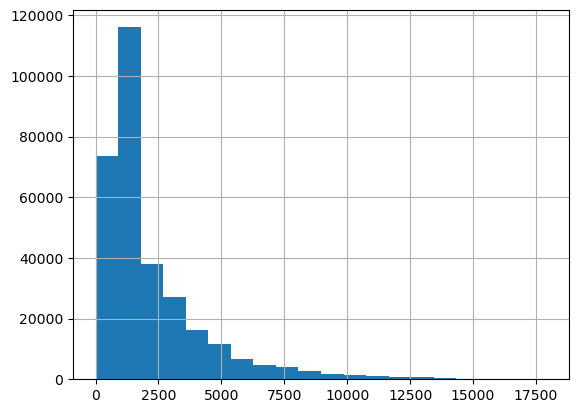

In [110]:
df_days_employed.hist(bins=20)

<Axes: >

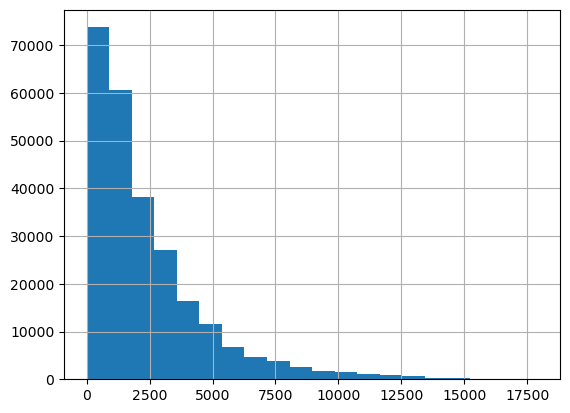

In [111]:
df[df['DAYS_EMPLOYED'] != 365243].DAYS_EMPLOYED.hist(bins=20)

In [112]:
df[df['DAYS_EMPLOYED'] == 365243].NAME_INCOME_TYPE.value_counts()

NAME_INCOME_TYPE
Pensioner     55352
Unemployed       22
Name: count, dtype: int64

#### Створимо нову колонку `YEARS_EMPLOYED` для зручності аналізу

In [113]:
df['YEARS_EMPLOYED'] = df['DAYS_EMPLOYED'].apply(lambda x: round(x/365))

### Аналіз стовпця `DAYS_REGISTRATION`

In [114]:
df['DAYS_REGISTRATION'].value_counts().head()

DAYS_REGISTRATION
-1.00    113
-7.00     98
-6.00     96
-4.00     92
-2.00     92
Name: count, dtype: int64

In [115]:
df['DAYS_REGISTRATION'].value_counts(normalize = True).head()

DAYS_REGISTRATION
-1.00   0.00
-7.00   0.00
-6.00   0.00
-4.00   0.00
-2.00   0.00
Name: proportion, dtype: float64

In [116]:
df['DAYS_REGISTRATION'].unique()

array([ -3648.,  -1186.,  -4260., ..., -16396., -14558., -14798.],
      shape=(15688,))

In [117]:
df['DAYS_REGISTRATION'].nunique()

15688

Перетворення `DAYS_REGISTRATION` в додатні дні

In [118]:
df['DAYS_REGISTRATION'] = df['DAYS_REGISTRATION'].apply(lambda x: -x if x < 0 else x)

In [119]:
df['DAYS_REGISTRATION'].value_counts().head()

DAYS_REGISTRATION
1.00    113
7.00     98
6.00     96
4.00     92
2.00     92
Name: count, dtype: int64

Всі дні в `DAYS_REGISTRATION` мають додатні значення

#### Створимо нову колонку `YEARS_REGISTRATION` для зручності аналізу

In [120]:
df['YEARS_REGISTRATION'] = df['DAYS_REGISTRATION'].apply(lambda x: round(x/365))

### Аналіз стовпця `DAYS_ID_PUBLISH`

In [121]:
df['DAYS_ID_PUBLISH'].value_counts().head()

DAYS_ID_PUBLISH
-4053    169
-4095    162
-4046    161
-4417    159
-4256    158
Name: count, dtype: int64

In [122]:
df['DAYS_ID_PUBLISH'].value_counts(normalize = True).head()

DAYS_ID_PUBLISH
-4053   0.00
-4095   0.00
-4046   0.00
-4417   0.00
-4256   0.00
Name: proportion, dtype: float64

In [123]:
df['DAYS_ID_PUBLISH'].unique()

array([-2120,  -291, -2531, ..., -6194, -5854, -6211], shape=(6168,))

In [124]:
df['DAYS_ID_PUBLISH'].nunique()

6168

Перетворення `DAYS_ID_PUBLISH` в додатні дні

In [125]:
df['DAYS_ID_PUBLISH'] = df['DAYS_ID_PUBLISH'].apply(lambda x: -x if x < 0 else x)

In [126]:
df['DAYS_ID_PUBLISH'].value_counts().head()

DAYS_ID_PUBLISH
4053    169
4095    162
4046    161
4417    159
4256    158
Name: count, dtype: int64

Всі дні в `DAYS_ID_PUBLISH` мають додатні значення

#### Створимо нову колонку `YEARS_ID_PUBLISH` для зручності аналізу

In [127]:
df['YEARS_ID_PUBLISH'] = df['DAYS_ID_PUBLISH'].apply(lambda x: round(x/365))

### Аналіз стовпця `DAYS_LAST_PHONE_CHANGE`

In [128]:
df['DAYS_LAST_PHONE_CHANGE'].value_counts().head()

DAYS_LAST_PHONE_CHANGE
0.00     37672
-1.00     2812
-2.00     2318
-3.00     1763
-4.00     1285
Name: count, dtype: int64

In [129]:
df['DAYS_LAST_PHONE_CHANGE'].value_counts(normalize = True).head()

DAYS_LAST_PHONE_CHANGE
0.00    0.12
-1.00   0.01
-2.00   0.01
-3.00   0.01
-4.00   0.00
Name: proportion, dtype: float64

In [130]:
df['DAYS_LAST_PHONE_CHANGE'].unique()

array([-1134.,  -828.,  -815., ..., -3988., -3899., -3538.], shape=(3774,))

In [131]:
df['DAYS_LAST_PHONE_CHANGE'].nunique()

3773

Перетворення `DAYS_LAST_PHONE_CHANGE` в додатні дні

In [132]:
df['DAYS_LAST_PHONE_CHANGE'] = df['DAYS_LAST_PHONE_CHANGE'].apply(lambda x: -x if x < 0 else x)

In [133]:
df['DAYS_LAST_PHONE_CHANGE'].value_counts().head()

DAYS_LAST_PHONE_CHANGE
0.00    37672
1.00     2812
2.00     2318
3.00     1763
4.00     1285
Name: count, dtype: int64

Всі дні в `DAYS_LAST_PHONE_CHANGE` мають додатні значення

#### Створення нової колонки `YEARS_LAST_PHONE_CHANGE` для зручності аналізу

In [134]:
df['YEARS_LAST_PHONE_CHANGE'] = df['DAYS_LAST_PHONE_CHANGE'].apply(lambda x: round(x/365,0))

# Функції для автоматизації

### Створення функції `age_cat` для категоризації даних, що містять інформацію про роки

In [135]:
def age_cat(years):
    if years <= 20:
        return '0-20'
    elif years > 20 and years <= 30:
        return '20-30'
    elif years > 30 and years <= 40:
        return '30-40'
    elif years > 40 and years <= 50:
        return '40-50'
    elif years > 50 and years <= 60:
        return '50-60'
    elif years > 60 and years <= 70:
        return '60-70'
    elif years > 70:
        return '70+'

### Одномірний (категоріальний vs цільовий) та двомірний (категоріальний vs категоріальний) аналіз (гістограма) - категоріальні стовпчики

In [136]:
import matplotlib.pyplot as plt


def bi_cat_countplot(df, column, hue_column):
    unique_hue_values = df[hue_column].unique()
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches(14,6)

    pltname = f'Нормалізований розподіл значень за категорією: {column}'
    proportions = df.groupby(hue_column)[column].value_counts(normalize=True)
    proportions = (proportions*100).round(2)
    ax = proportions.unstack(hue_column).sort_values(
        by=unique_hue_values[0], ascending=False
        ).plot.bar(ax=axes[0], title=pltname)

    # анотація значень в барплоті
    for container in ax.containers:
        ax.bar_label(container, fmt='{:,.1f}%')

    pltname = f'Кількість даних за категорією: {column}'
    counts = df.groupby(hue_column)[column].value_counts()
    ax = counts.unstack(hue_column).sort_values(
        by=unique_hue_values[0], ascending=False
        ).plot.bar(ax=axes[1], title=pltname)

    for container in ax.containers:
      ax.bar_label(container)


def uni_cat_target_compare(df, column):
    bi_cat_countplot(df, column, hue_column='TARGET')


### Обчислення мінімального та максимального діапазону відхилень для числових стовпців

In [137]:
def outlier_range(dataset,column):
    Q1 = dataset[column].quantile(0.25)
    Q3 = dataset[column].quantile(0.75)
    IQR = Q3 - Q1
    Min_value = (Q1 - 1.5 * IQR)
    Max_value = (Q3 + 1.5 * IQR)
    return Max_value

### Робота з викидами для числових стовпців

In [139]:
import warnings

def dist_box(dataset, column):
    with warnings.catch_warnings():
      warnings.simplefilter("ignore")

      plt.figure(figsize=(16,6))

      plt.subplot(1,2,1)
      sns.distplot(dataset[column], color = 'purple')
      pltname = 'Графік розподілу для ' + column
      plt.ticklabel_format(style='plain', axis='x')
      plt.title(pltname)

      plt.subplot(1,2,2)
      red_diamond = dict(markerfacecolor='r', marker='D')
      sns.boxplot(y = column, data = dataset, flierprops = red_diamond)
      pltname = 'Боксплот для ' + column
      plt.title(pltname)

      plt.show()

**Custom logic: 4** - implement new dist_box method similar to the one above but not based on deprecated seaborn method

In [140]:
from mlpeople.visualization.distributions.distplots import draw_dist_box

### Аналіз стовпця`CNT_CHILDREN`

In [ ]:
df['CNT_CHILDREN'].value_counts().sort_values(ascending = False);

In [ ]:
(df['CNT_CHILDREN'].value_counts(normalize = True).sort_values(ascending = False) * 100).head()

CNT_CHILDREN
0   70.04
1   19.88
2    8.70
3    1.21
4    0.14
Name: proportion, dtype: float64

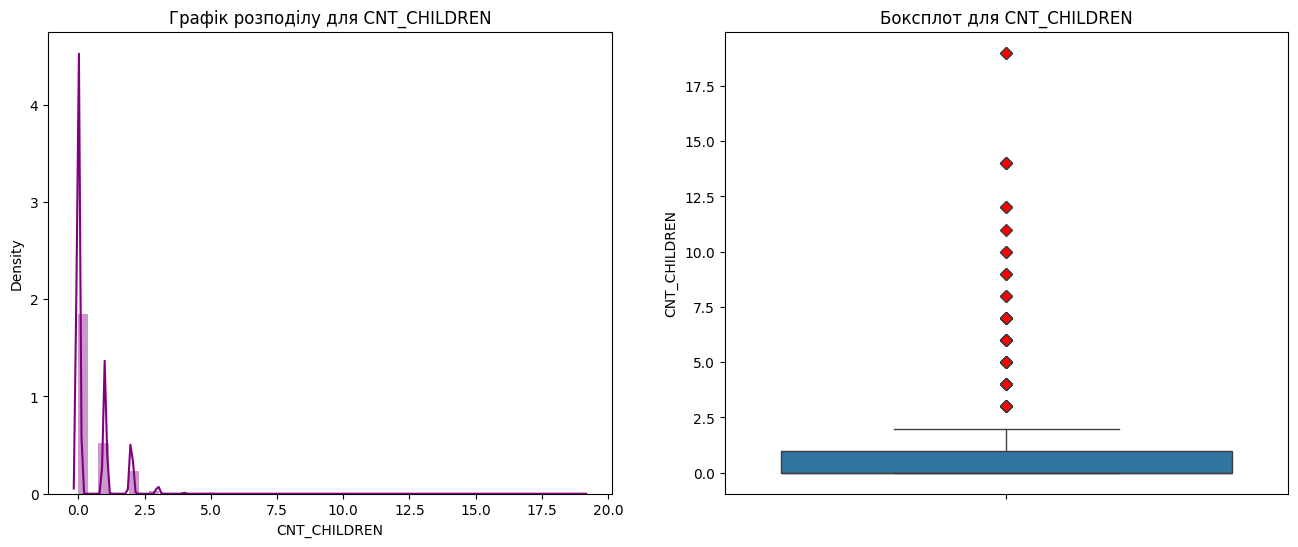

In [ ]:
dist_box(df,'CNT_CHILDREN')

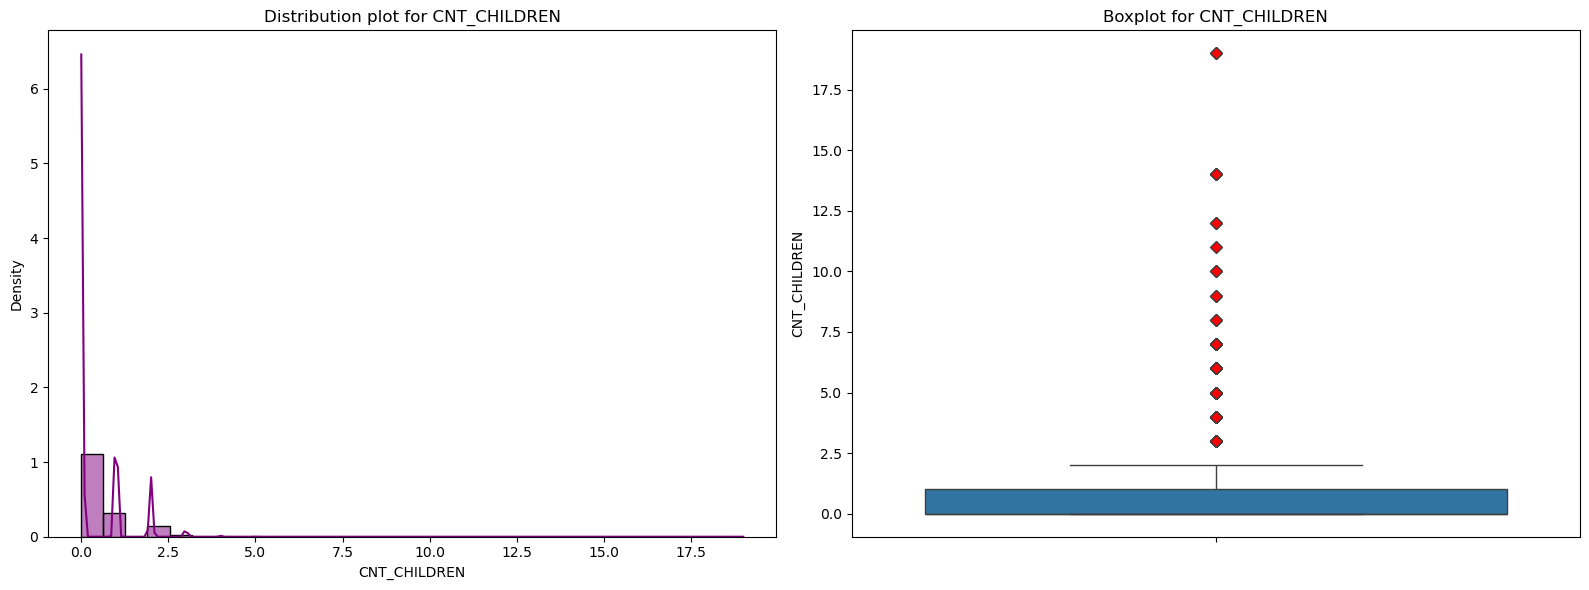

In [141]:
draw_dist_box(df, 'CNT_CHILDREN')

Розрахуємо IQR (Inter Quartile range)

In [142]:
Q1 = df['CNT_CHILDREN'].quantile(0.25)
Q3 = df['CNT_CHILDREN'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

1.0


In [143]:
Q1, Q3

(np.float64(0.0), np.float64(1.0))

Значення *до* (Q1 - 1,5 * IQR) та *після* (Q3 + 1,5 * IQR) є викидами

In [144]:
Min_value = (Q1 - 1.5 * IQR)
Max_value = (Q3 + 1.5 * IQR)
print("Мінімальне значення, до якого існують викиди: {}".format(Min_value))
print("Максимальне значення, після якого існують викиди: {}".format(Max_value))

Мінімальне значення, до якого існують викиди: -1.5
Максимальне значення, після якого існують викиди: 2.5


In [145]:
df[df['CNT_CHILDREN'].isin(range(10,20))].YEARS_BIRTH

34545     47
80948     39
132585    31
155369    30
171125    38
176011    49
183878    56
186820    41
265784    28
267998    42
Name: YEARS_BIRTH, dtype: int64

In [146]:
df[df['CNT_CHILDREN'].isin([10])][['SK_ID_CURR', 'CNT_CHILDREN', 'YEARS_BIRTH']]

SK_ID_CURR  CNT_CHILDREN  YEARS_BIRTH
132585      253779            10           31
186820      316580            10           41

**Спостереження**
- Дивлячись на дані, ми бачимо, що кількість заявників, які мають більше 7 дітей, є дуже мінімальною (2 або 3 в кожній категорії)
- Крім того, дивлячись на дані для заявників з 10 дітьми, заявники мають лише 31 й 41 рік відповідно. Це виглядає як одиничний випадок й може розглядатися як відхилення від норми
- Як дистрибутивні, так і діаграми розмаху чітко показують, що значення, які перевищують значення 2.5, є відхиленнями від норми.

**Висновок**
- Заявники, які мають 3 або більше дітей, є випадками, що відхиляються від норми. Ми можемо надати спеціальний аналіз для цих випадків.

### Аналіз стовпця `AMT_INCOME_TOTAL`

In [147]:
df['AMT_INCOME_TOTAL'].value_counts().sort_values(ascending = False).head()

AMT_INCOME_TOTAL
135000.00    35750
112500.00    31019
157500.00    26556
180000.00    24719
90000.00     22483
Name: count, dtype: int64

In [148]:
(df['AMT_INCOME_TOTAL'].value_counts(normalize = True).sort_values(ascending = False) * 100).head()

AMT_INCOME_TOTAL
135000.00   11.63
112500.00   10.09
157500.00    8.64
180000.00    8.04
90000.00     7.31
Name: proportion, dtype: float64

In [149]:
df['AMT_INCOME_TOTAL'].describe(percentiles = [0.75,0.99,0.999])

count      307511.00
mean       168797.92
std        237123.15
min         25650.00
50%        147150.00
75%        202500.00
99%        472500.00
99.9%      900000.00
max     117000000.00
Name: AMT_INCOME_TOTAL, dtype: float64

Побудуємо графік для `AMT_INCOME_TOTAL`

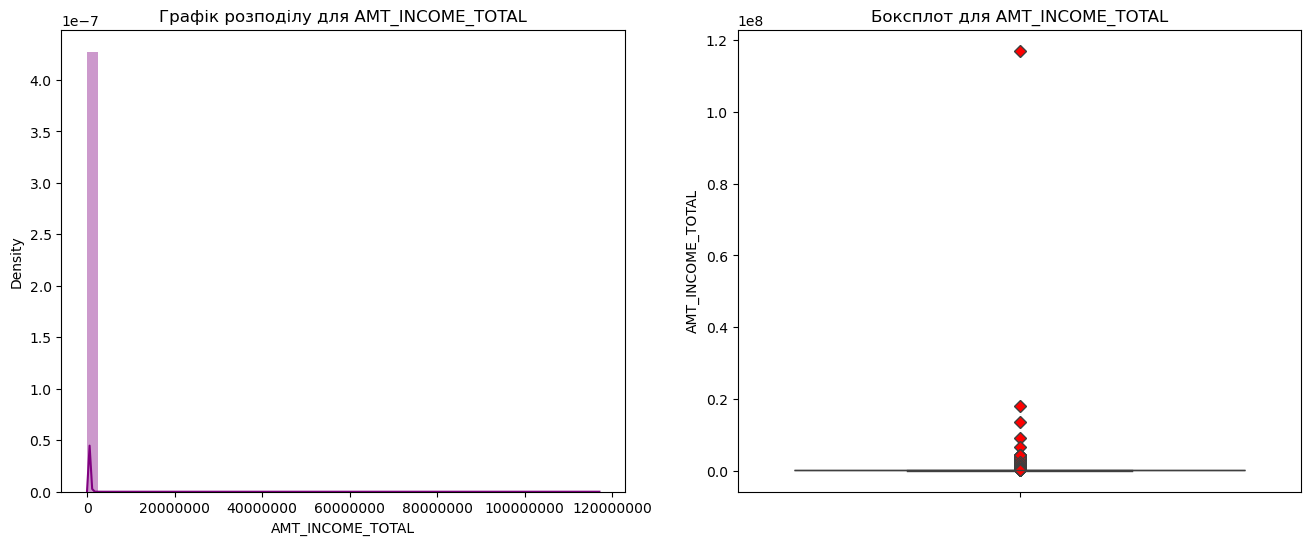

In [150]:
dist_box(df,'AMT_INCOME_TOTAL')

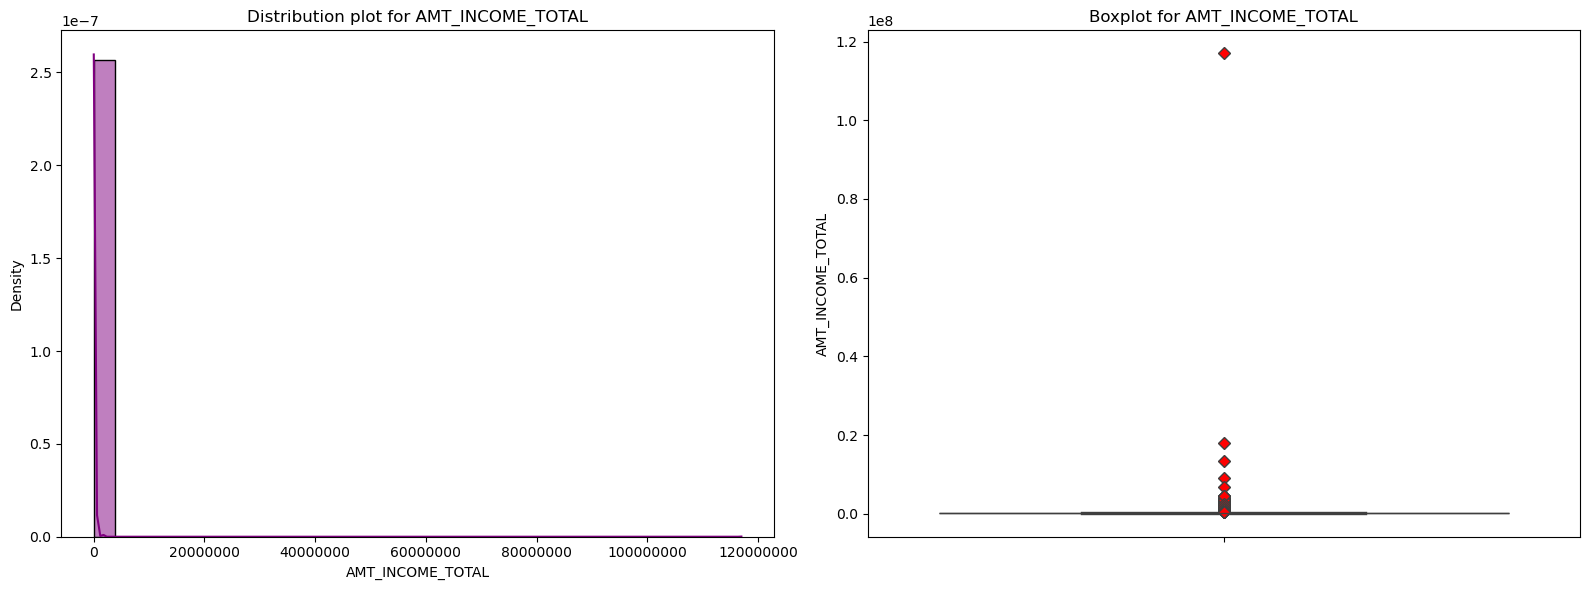

In [151]:
draw_dist_box(df,'AMT_INCOME_TOTAL')

- Графіки кінцевого результату дуже тонкі, й ми можемо спостерігати викид близько ~120 мільйонів.
- Давайте побудуємо графік, розглядаючи лише дохід нижче 99,9% значення, тобто 900 тисяч.

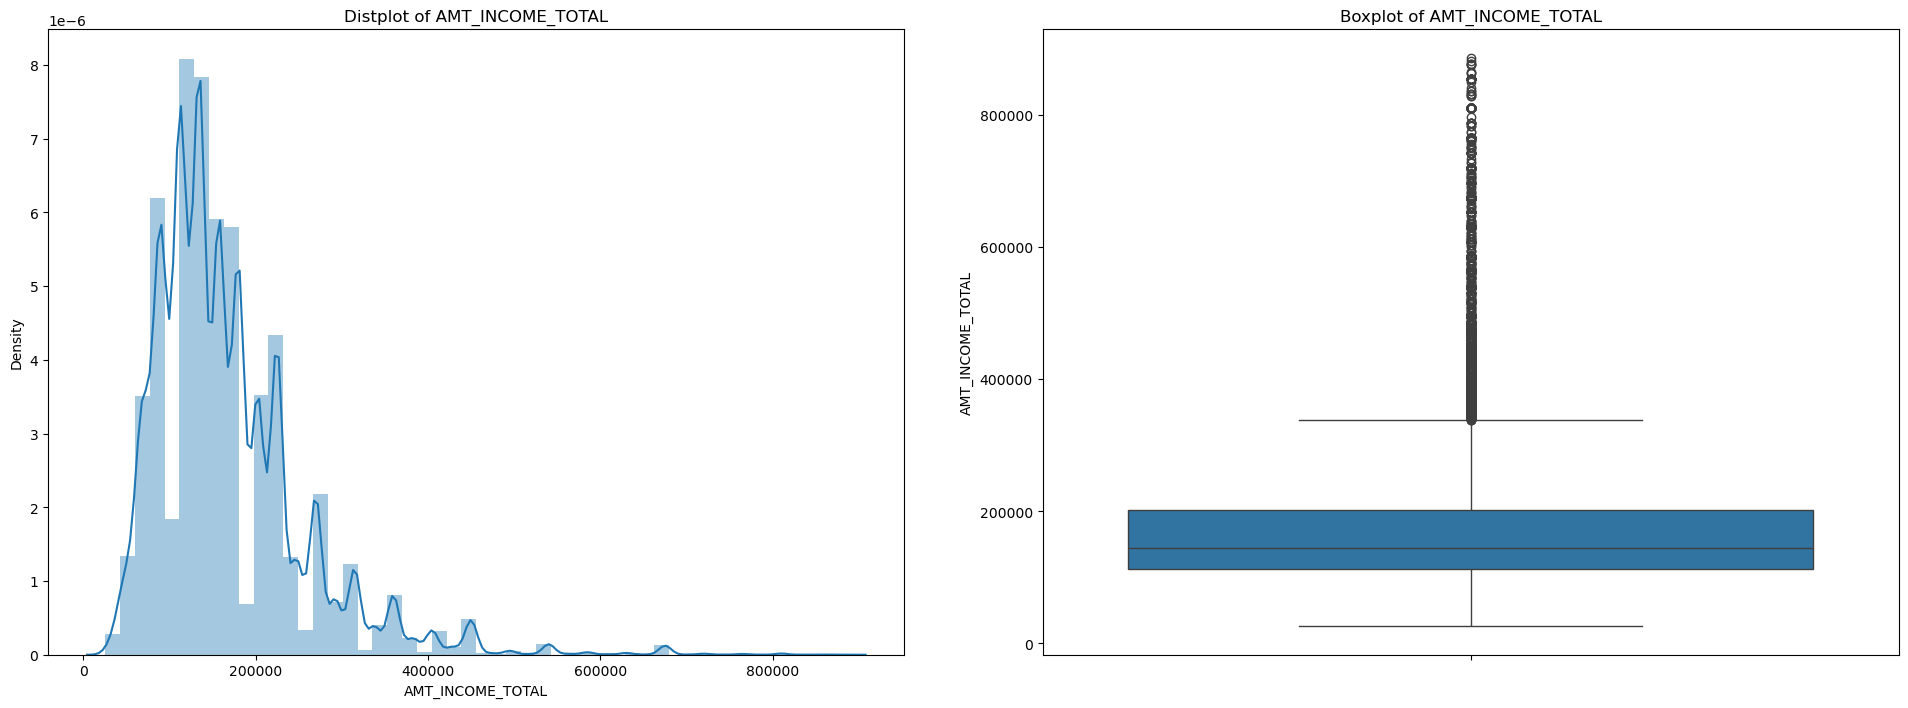

In [152]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plt.subplots(1,2 ,figsize = (20,8))

    plt.subplot(121)
    sns.distplot(df[df['AMT_INCOME_TOTAL'] < 900000].AMT_INCOME_TOTAL)
    pltname = 'Distplot of ' + 'AMT_INCOME_TOTAL'
    plt.title(pltname)

    plt.subplot(122)
    sns.boxplot(df[df['AMT_INCOME_TOTAL'] < 900000].AMT_INCOME_TOTAL)
    pltname = 'Boxplot of ' + 'AMT_INCOME_TOTAL'
    plt.title(pltname)

    plt.tight_layout(pad = 4)
    plt.show()

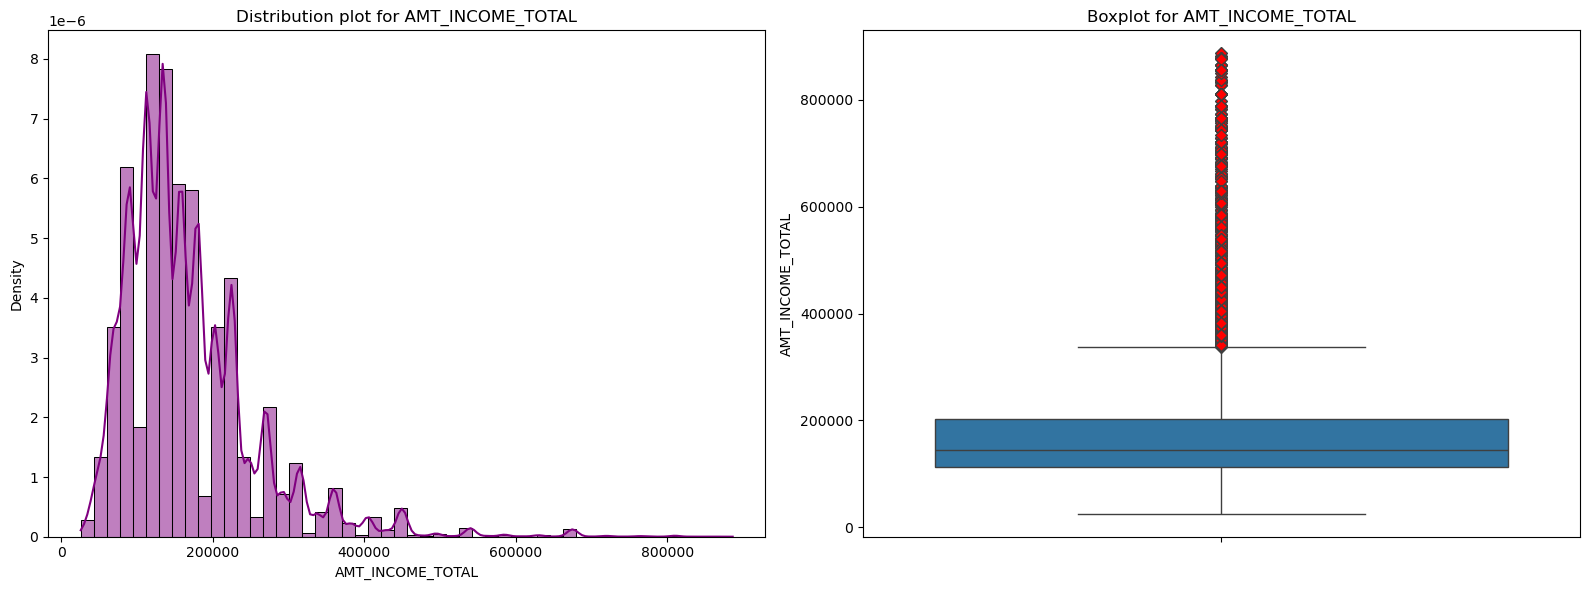

In [153]:
draw_dist_box(df[df['AMT_INCOME_TOTAL'] < 900000],'AMT_INCOME_TOTAL', bins=50, bw_adjust=1)

Тепер ми можемо чітко побачити розподіл і діапазон даних на обох графіках.
 - Це означає, що значення понад 900 тис. грн доходу явно є викидами

In [154]:
df[df['AMT_INCOME_TOTAL'] > 900000].head()

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE CODE_GENDER  FLAG_OWN_CAR  \
1504      101769       0                0.00           M          1.00   
1723      102015       0                1.00           F          0.00   
3371      103938       0                1.00           F          0.00   
4603      105384       0                0.00           F          1.00   
5673      106637       0                1.00           M          1.00   

      FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
1504             1.00             0        1080000.00   180000.00   
1723             1.00             0        1935000.00   269550.00   
3371             0.00             1        1350000.00  2410380.00   
4603             1.00             0        1350000.00   405000.00   
5673             1.00             3         967500.00   450000.00   

      AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
1504      9000.00        180000.00   Unaccompanied  Commercial associate   
1723     10534.50        225000.00   Unaccompanied             Pensioner   
3371    109053.00       2250000.00              NA  Commercial associate   
4603     20250.00        405000.00   Unaccompanied  Commercial associate   
5673     30073.50        450000.00   Unaccompanied  Commercial associate   

                NAME_EDUCATION_TYPE NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
1504               Higher education            Married  House / apartment   
1723  Secondary / secondary special            Married  House / apartment   
3371               Higher education            Married  House / apartment   
4603               Higher education            Married  House / apartment   
5673               Higher education            Married  House / apartment   

      REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
1504                        0.07       13633           5536   
1723                        0.01       18636         365243   
3371                        0.07       12213            843   
4603                        0.02       14781           4768   
5673                        0.05       11901            546   

      DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  FLAG_EMP_PHONE  \
1504               3.00             4971           1               1   
1723            3401.00             2168           1               0   
3371             757.00             4132           1               1   
4603            3469.00             4045           1               1   
5673            2932.00              215           1               1   

      FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
1504                0                 1           0           0   
1723                0                 1           1           0   
3371                0                 1           1           0   
4603                0                 1           0           0   
5673                0                 1           0           0   

     OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
1504         Unknown             2.00                     1   
1723         Unknown             2.00                     2   
3371        Managers             3.00                     1   
4603        Managers             2.00                     2   
5673        Managers             5.00                     1   

      REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
1504                            1                     FRIDAY   
1723                            2                     MONDAY   
3371                            1                     SUNDAY   
4603                            2                    TUESDAY   
5673                            1                     MONDAY   

      HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
1504                       13                           0   
1723                       11                           0   
3371                       13                           0   
460

**Спостереження**
- Дивлячись на дані, ми бачимо, що дохід понад 900 тис. грн (99,9% значення) є викидом
- Як діаграма розподілу, так і діаграма розмаху чітко показують нам ту саму тенденцію

**Висновок**
- Апліканти з доходом понад 900 тис. грн (99,9% значення) є викидами

# Розбиття на біни безперервних колонок для аналізу

### Категоризація стовпця `AMT_GOODS_PRICE

In [155]:
df['AMT_GOODS_PRICE'].value_counts().sort_values(ascending = False).head()

AMT_GOODS_PRICE
450000.00    26022
225000.00    25282
675000.00    24962
900000.00    15416
270000.00    11428
Name: count, dtype: int64

In [156]:
(df['AMT_GOODS_PRICE'].value_counts(normalize = True).sort_values(ascending = False) * 100).head()

AMT_GOODS_PRICE
450000.00   8.47
225000.00   8.23
675000.00   8.12
900000.00   5.02
270000.00   3.72
Name: proportion, dtype: float64

Подивимось статистичний звіт для `AMT_GOODS_PRICE

In [157]:
df['AMT_GOODS_PRICE'].describe(percentiles = [0.25,0.75,0.99,0.9999])

count     307233.00
mean      538396.21
std       369446.46
min        40500.00
25%       238500.00
50%       450000.00
75%       679500.00
99%      1800000.00
99.99%   2934964.80
max      4050000.00
Name: AMT_GOODS_PRICE, dtype: float64

Розподілимо значення в `AMT_GOODS_PRICE` на 5 бінів і створимо новий стовпець `AMT_GOODS_PRICE_CATEGORY`.

In [158]:
df['AMT_GOODS_PRICE_CATEGORY'] = pd.cut(df['AMT_GOODS_PRICE'],
                                        bins = 5, labels = ['very low', 'low', 'medium', 'high', 'very high'])

Перевірка заповнення значень згідно з очікуванням

In [159]:
df['AMT_GOODS_PRICE_CATEGORY'].value_counts()

AMT_GOODS_PRICE_CATEGORY
very low     246973
low           56087
medium         4108
high             47
very high        18
Name: count, dtype: int64

**Custom logic: 5** - create custom categorization (binning) methods

In [163]:
from mlpeople.eda.categorization.binning import (
    pd_cut_by_quantiles,
    pd_qcut_by_quantiles,
    pd_cut_by_values
)

In [165]:
df['AMT_GOODS_PRICE_CATEGORY'] = pd_cut_by_values(df['AMT_GOODS_PRICE'])
df['AMT_GOODS_PRICE_CATEGORY'].value_counts()

AMT_GOODS_PRICE_CATEGORY
medium            116081
low                71306
high               49677
very low           39484
very high          15957
upper outliers     14728
lower outliers         0
Name: count, dtype: int64

In [166]:
df['AMT_GOODS_PRICE_CATEGORY'] = pd_cut_by_quantiles(df['AMT_GOODS_PRICE'])
df['AMT_GOODS_PRICE_CATEGORY'].value_counts()

AMT_GOODS_PRICE_CATEGORY
medium       116081
low           71306
high          49677
very low      39484
very high     30685
Name: count, dtype: int64

In [167]:
df['AMT_GOODS_PRICE_CATEGORY'] = pd_qcut_by_quantiles(df['AMT_GOODS_PRICE'])
df['AMT_GOODS_PRICE_CATEGORY'].value_counts()

AMT_GOODS_PRICE_CATEGORY
medium       116081
low           71306
high          49677
very low      39484
very high     30685
Name: count, dtype: int64

### Категоризація стовпця `YEARS_BIRTH`

Ми будемо класифікувати `YEARS_BIRTH` замість `DAYS_BIRTH`, оскільки роки легше інтерпретувати, ніж дні

In [168]:
df['YEARS_BIRTH'].value_counts().sort_values(ascending = False).head()

YEARS_BIRTH
39    9023
38    8793
37    8727
40    8602
41    8495
Name: count, dtype: int64

In [169]:
(df['YEARS_BIRTH'].value_counts(normalize = True).sort_values(ascending = False) * 100).head()

YEARS_BIRTH
39   2.93
38   2.86
37   2.84
40   2.80
41   2.76
Name: proportion, dtype: float64

Подивимось статистичний звіт для  `YEARS_BIRTH`

In [170]:
df['YEARS_BIRTH'].describe(percentiles = [0.25,0.75,0.99,0.9999])

count    307511.00
mean         43.94
std          11.96
min          21.00
25%          34.00
50%          43.00
75%          54.00
99%          67.00
99.99%       69.00
max          69.00
Name: YEARS_BIRTH, dtype: float64

Категоризуймо значення з `YEARS_BIRTH` у новий стовпець `YEARS_BIRTH_CATEGORY`.

In [171]:
df['YEARS_BIRTH_CATEGORY'] = df['YEARS_BIRTH'].apply(age_cat)

Перевірка заповнення значень згідно з очікуванням

In [172]:
df['YEARS_BIRTH_CATEGORY'].value_counts().sort_values(ascending = False)

YEARS_BIRTH_CATEGORY
30-40    82770
40-50    75509
50-60    67955
20-30    48869
60-70    32408
Name: count, dtype: int64

### Категоризація стовпця `YEARS_REGISTRATION`

Ми будемо класифікувати `YEARS_REGISTRATION` замість `DAYS_REGISTRATION`, оскільки роки легше інтерпретувати, ніж дні

In [173]:
df['YEARS_REGISTRATION'].value_counts().sort_values(ascending = False).head()

YEARS_REGISTRATION
1     15661
2     15564
3     13894
13    12866
12    12697
Name: count, dtype: int64

In [174]:
(df['YEARS_REGISTRATION'].value_counts(normalize = True).sort_values(ascending = False) * 100).head()

YEARS_REGISTRATION
1    5.09
2    5.06
3    4.52
13   4.18
12   4.13
Name: proportion, dtype: float64

Подивимось статистичний звіт для `YEARS_REGISTRATION`

In [175]:
df['YEARS_REGISTRATION'].describe(percentiles = [0.25,0.75,0.99,0.9999])

count    307511.00
mean         13.66
std           9.66
min           0.00
25%           6.00
50%          12.00
75%          20.00
99%          38.00
99.99%       54.25
max          68.00
Name: YEARS_REGISTRATION, dtype: float64

Категоризуймо значення з `YEARS_REGISTRATION` в новий стовпець `YEARS_REGISTRATION_CATEGORY`.

In [176]:
df['YEARS_REGISTRATION_CATEGORY'] = df['YEARS_REGISTRATION'].apply(age_cat)

Перевірка заповнення значень згідно з очікуванням

In [177]:
df['YEARS_REGISTRATION_CATEGORY'].value_counts().sort_values(ascending = False)

YEARS_REGISTRATION_CATEGORY
0-20     230697
20-30     59288
30-40     16051
40-50      1406
50-60        60
60-70         9
Name: count, dtype: int64

# Зберігання оновлених даних зі стисненням

In [ ]:
# filename = "drive/MyDrive/Machine Learning для людей/data/credit/application_data_processed"
# compression_options = dict(method='zip', archive_name=f'{filename}.csv')
# df.to_csv(f'{filename}.zip', compression=compression_options, index=False)

**Custom logic: 6** - move save file to method and separate oython file

In [179]:
from mlpeople.io import save_df_zip_csv

save_df_zip_csv(df, 'downloads/application_data_processed_v2')

In [ ]:
# якщо Вам треба буде зчитати оновлені дані - замініть шлях на свій і можна зчитати їх тут
# df = pd.read_csv('drive/MyDrive/Machine Learning для людей/data/credit/application_data_processed.zip')

# Перевірка дисбалансу для цільового стовпця `TARGET`

### Аналіз стовпця `TARGET`

In [180]:
df['TARGET'].value_counts().sort_values(ascending = False)

TARGET
0    282686
1     24825
Name: count, dtype: int64

In [181]:
df['TARGET'].value_counts(normalize = True).sort_values(ascending = False) * 100

TARGET
0   91.93
1    8.07
Name: proportion, dtype: float64

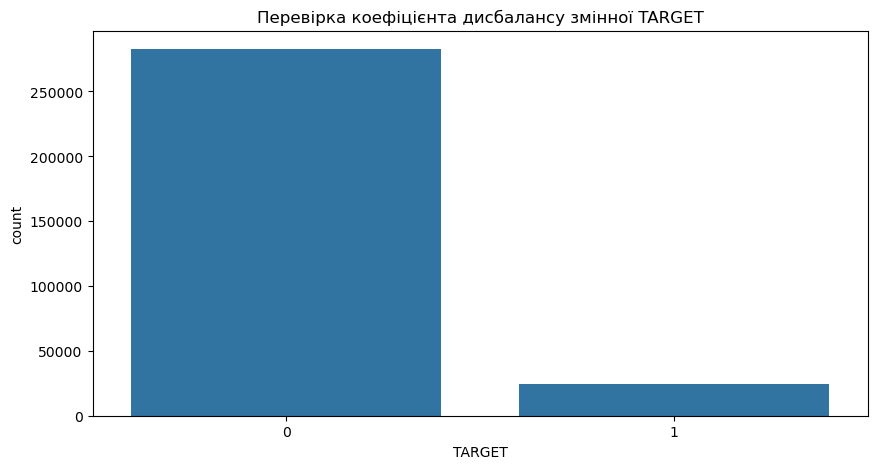

In [182]:
plt.figure(figsize = (10,5))
sns.countplot(x = df['TARGET'], data = df)
plt.title('Перевірка коефіцієнта дисбалансу змінної TARGET')
plt.show()

**Спостереження**

- Ми маємо дисбаланс у змінній `TARGET` на основі % спостережень
 - Значення `TARGET` 1 - це клієнт, який має труднощі з оплатою (прострочення платежу більше ніж на X днів принаймні за одним з перших Y платежів за кредитом). Це лише 8,07% даних
 - Значення `TARGET` 0 - всі інші випадки, окрім 1. Це 91,93% даних

# Розподіл даних на основі `TARGET`

### Створіть новий фрейм даних зі значенням `TARGET` 1
- Значення `TARGET` 1 представляє клієнта з платіжними труднощами (він/вона прострочив платіж більш ніж на X днів принаймні по одному з перших Y платежів за кредитом). Це лише 8,07% даних

In [183]:
df1 = df[df['TARGET'] == 1]

In [184]:
df1.TARGET.value_counts()

TARGET
1    24825
Name: count, dtype: int64

### Створити новий фрейм даних зі значенням `TARGET` 0
- Значення `TARGET` 0 представляє всі інші випадки, крім 1. Це 91.93% даних

In [185]:
df0 = df[df['TARGET'] == 0]

In [186]:
df0.TARGET.value_counts()

TARGET
0    282686
Name: count, dtype: int64

# Одномірний аналіз категоріальних змінних

### Аналіз стовпця `NAME_CONTRACT_TYPE`

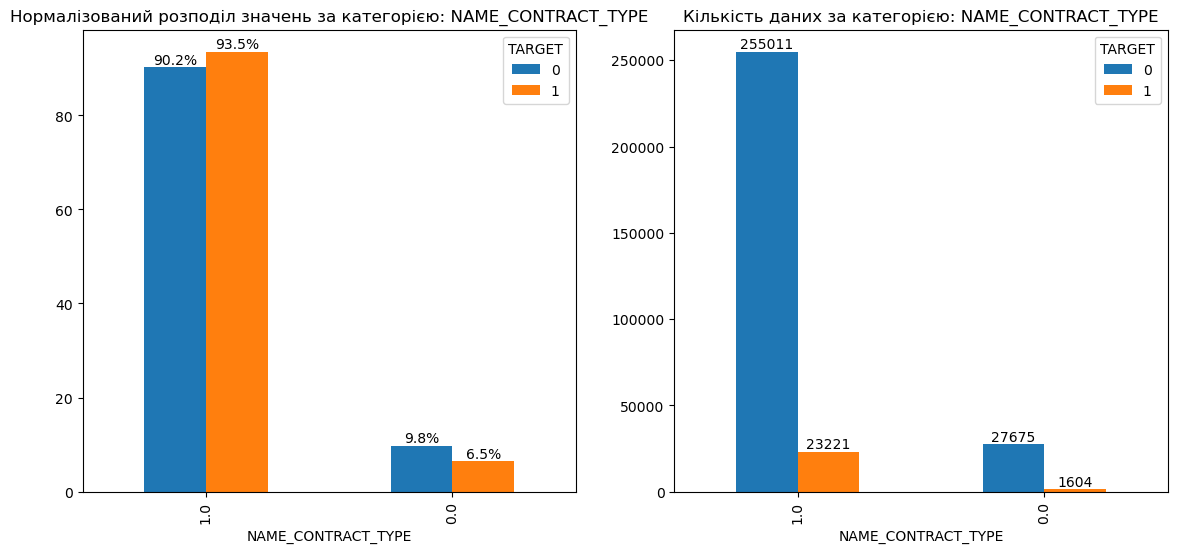

In [187]:
uni_cat_target_compare(df, 'NAME_CONTRACT_TYPE')

**Спостереження**

- Дивлячись на гістограми, ми не бачимо суттєвих відмінностей у `NAME_CONTRACT_TYPE` між клієнтами, які мають труднощі з оплатою, та клієнтами, які платять вчасно

**Висновок**
- Колонка `NAME_CONTRACT_TYPE` не надає жодних переконливих доказів на користь клієнтів, які мають труднощі з оплатою АБО вчасно сплачують

**Custom logic: 7** - move countplot to python file methods

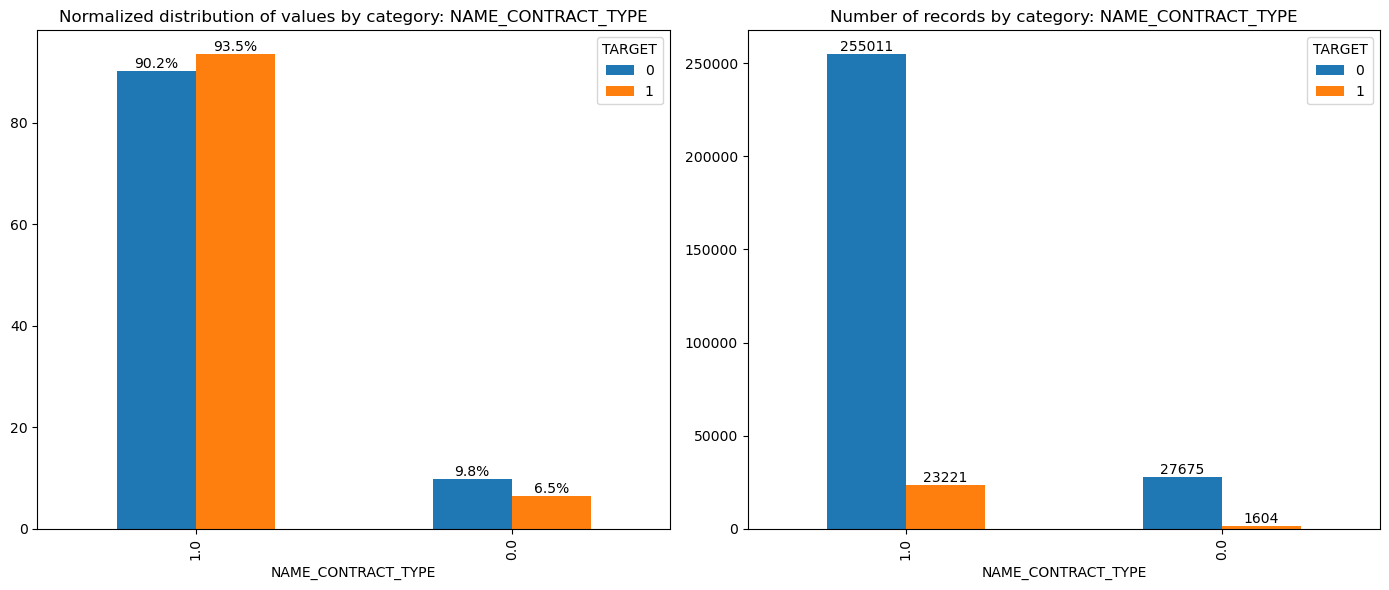

In [191]:
# import importlib

# import mlpeople.visualization.categorical.countplots as countplots

# importlib.reload(countplots)

from mlpeople.visualization.categorical.countplots import uni_cat_target_compare

uni_cat_target_compare(df, 'NAME_CONTRACT_TYPE', hue_column='TARGET')

# Кореляційний аналіз числових змінних

### Побудова кореляційної матриці для випадків із платіжними труднощами

In [192]:
df1.select_dtypes(include='number').shape

(24825, 70)

Є 67 числових стовпчиків. Створимо кореляційну матрицб `corr` для кращого перегляду результатів

In [193]:
corr_df1 = df1.select_dtypes(include='number').corr()

In [194]:
corr_df1.head()

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  FLAG_OWN_CAR  \
SK_ID_CURR                1.00     NaN               -0.00          0.00   
TARGET                     NaN     NaN                 NaN           NaN   
NAME_CONTRACT_TYPE       -0.00     NaN                1.00          0.01   
FLAG_OWN_CAR              0.00     NaN                0.01          1.00   
FLAG_OWN_REALTY          -0.00     NaN               -0.07          0.02   

                    FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  \
SK_ID_CURR                    -0.00         -0.01             -0.01   
TARGET                          NaN           NaN               NaN   
NAME_CONTRACT_TYPE            -0.07         -0.01              0.01   
FLAG_OWN_CAR                   0.02          0.07              0.02   
FLAG_OWN_REALTY                1.00          0.02              0.01   

                    AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
SK_ID_CURR               -0.00        -0.01            -0.00   
TARGET                     NaN          NaN              NaN   
NAME_CONTRACT_TYPE        0.23         0.29             0.19   
FLAG_OWN_CAR              0.10         0.14             0.10   
FLAG_OWN_REALTY          -0.01         0.00            -0.02   

                    REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
SK_ID_CURR                                0.01        0.00          -0.01   
TARGET                                     NaN         NaN            NaN   
NAME_CONTRACT_TYPE                        0.00        0.08           0.03   
FLAG_OWN_CAR                              0.03       -0.07          -0.11   
FLAG_OWN_REALTY                           0.03        0.11           0.06   

                    DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  \
SK_ID_CURR                      -0.01             0.00         NaN   
TARGET                            NaN              NaN         NaN   
NAME_CONTRACT_TYPE               0.01             0.08         NaN   
FLAG_OWN_CAR                    -0.07             0.02         NaN   
FLAG_OWN_REALTY                  0.01            -0.02         NaN   

                    FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  \
SK_ID_CURR                    0.01             0.00             -0.00   
TARGET                         NaN              NaN               NaN   
NAME_CONTRACT_TYPE           -0.03             0.01              0.11   
FLAG_OWN_CAR                  0.11            -0.02              0.00   
FLAG_OWN_REALTY              -0.06            -0.14             -0.01   

                    FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
SK_ID_CURR                0.02        0.00            -0.00   
TARGET                     NaN         NaN              NaN   
NAME_CONTRACT_TYPE        0.00        0.02             0.00   
FLAG_OWN_CAR             -0.00        0.03             0.11   
FLAG_OWN_REALTY          -0.05        0.03             0.03   

                    REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
SK_ID_CURR                         -0.01                        -0.00   
TARGET                               NaN                          NaN   
NAME_CONTRACT_TYPE                  0.01                         0.01   
FLAG_OWN_CAR                       -0.01                        -0.01   
FLAG_OWN_REALTY                    -0.01                        -0.01   

                    HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
SK_ID_CURR                             0.01                       -0.00   
TARGET                                  NaN                         NaN   
NAME_CONTRACT_TYPE                    -0.02                       -0.01   
FLAG_OWN_CAR                           0.01                       -0.00   
FLAG_OWN_REALTY                       -0.12                       -0.05   

                    REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
SK_ID_CURR                                0.00                         0.00   
T

Перегляд повної кореляційної матриці

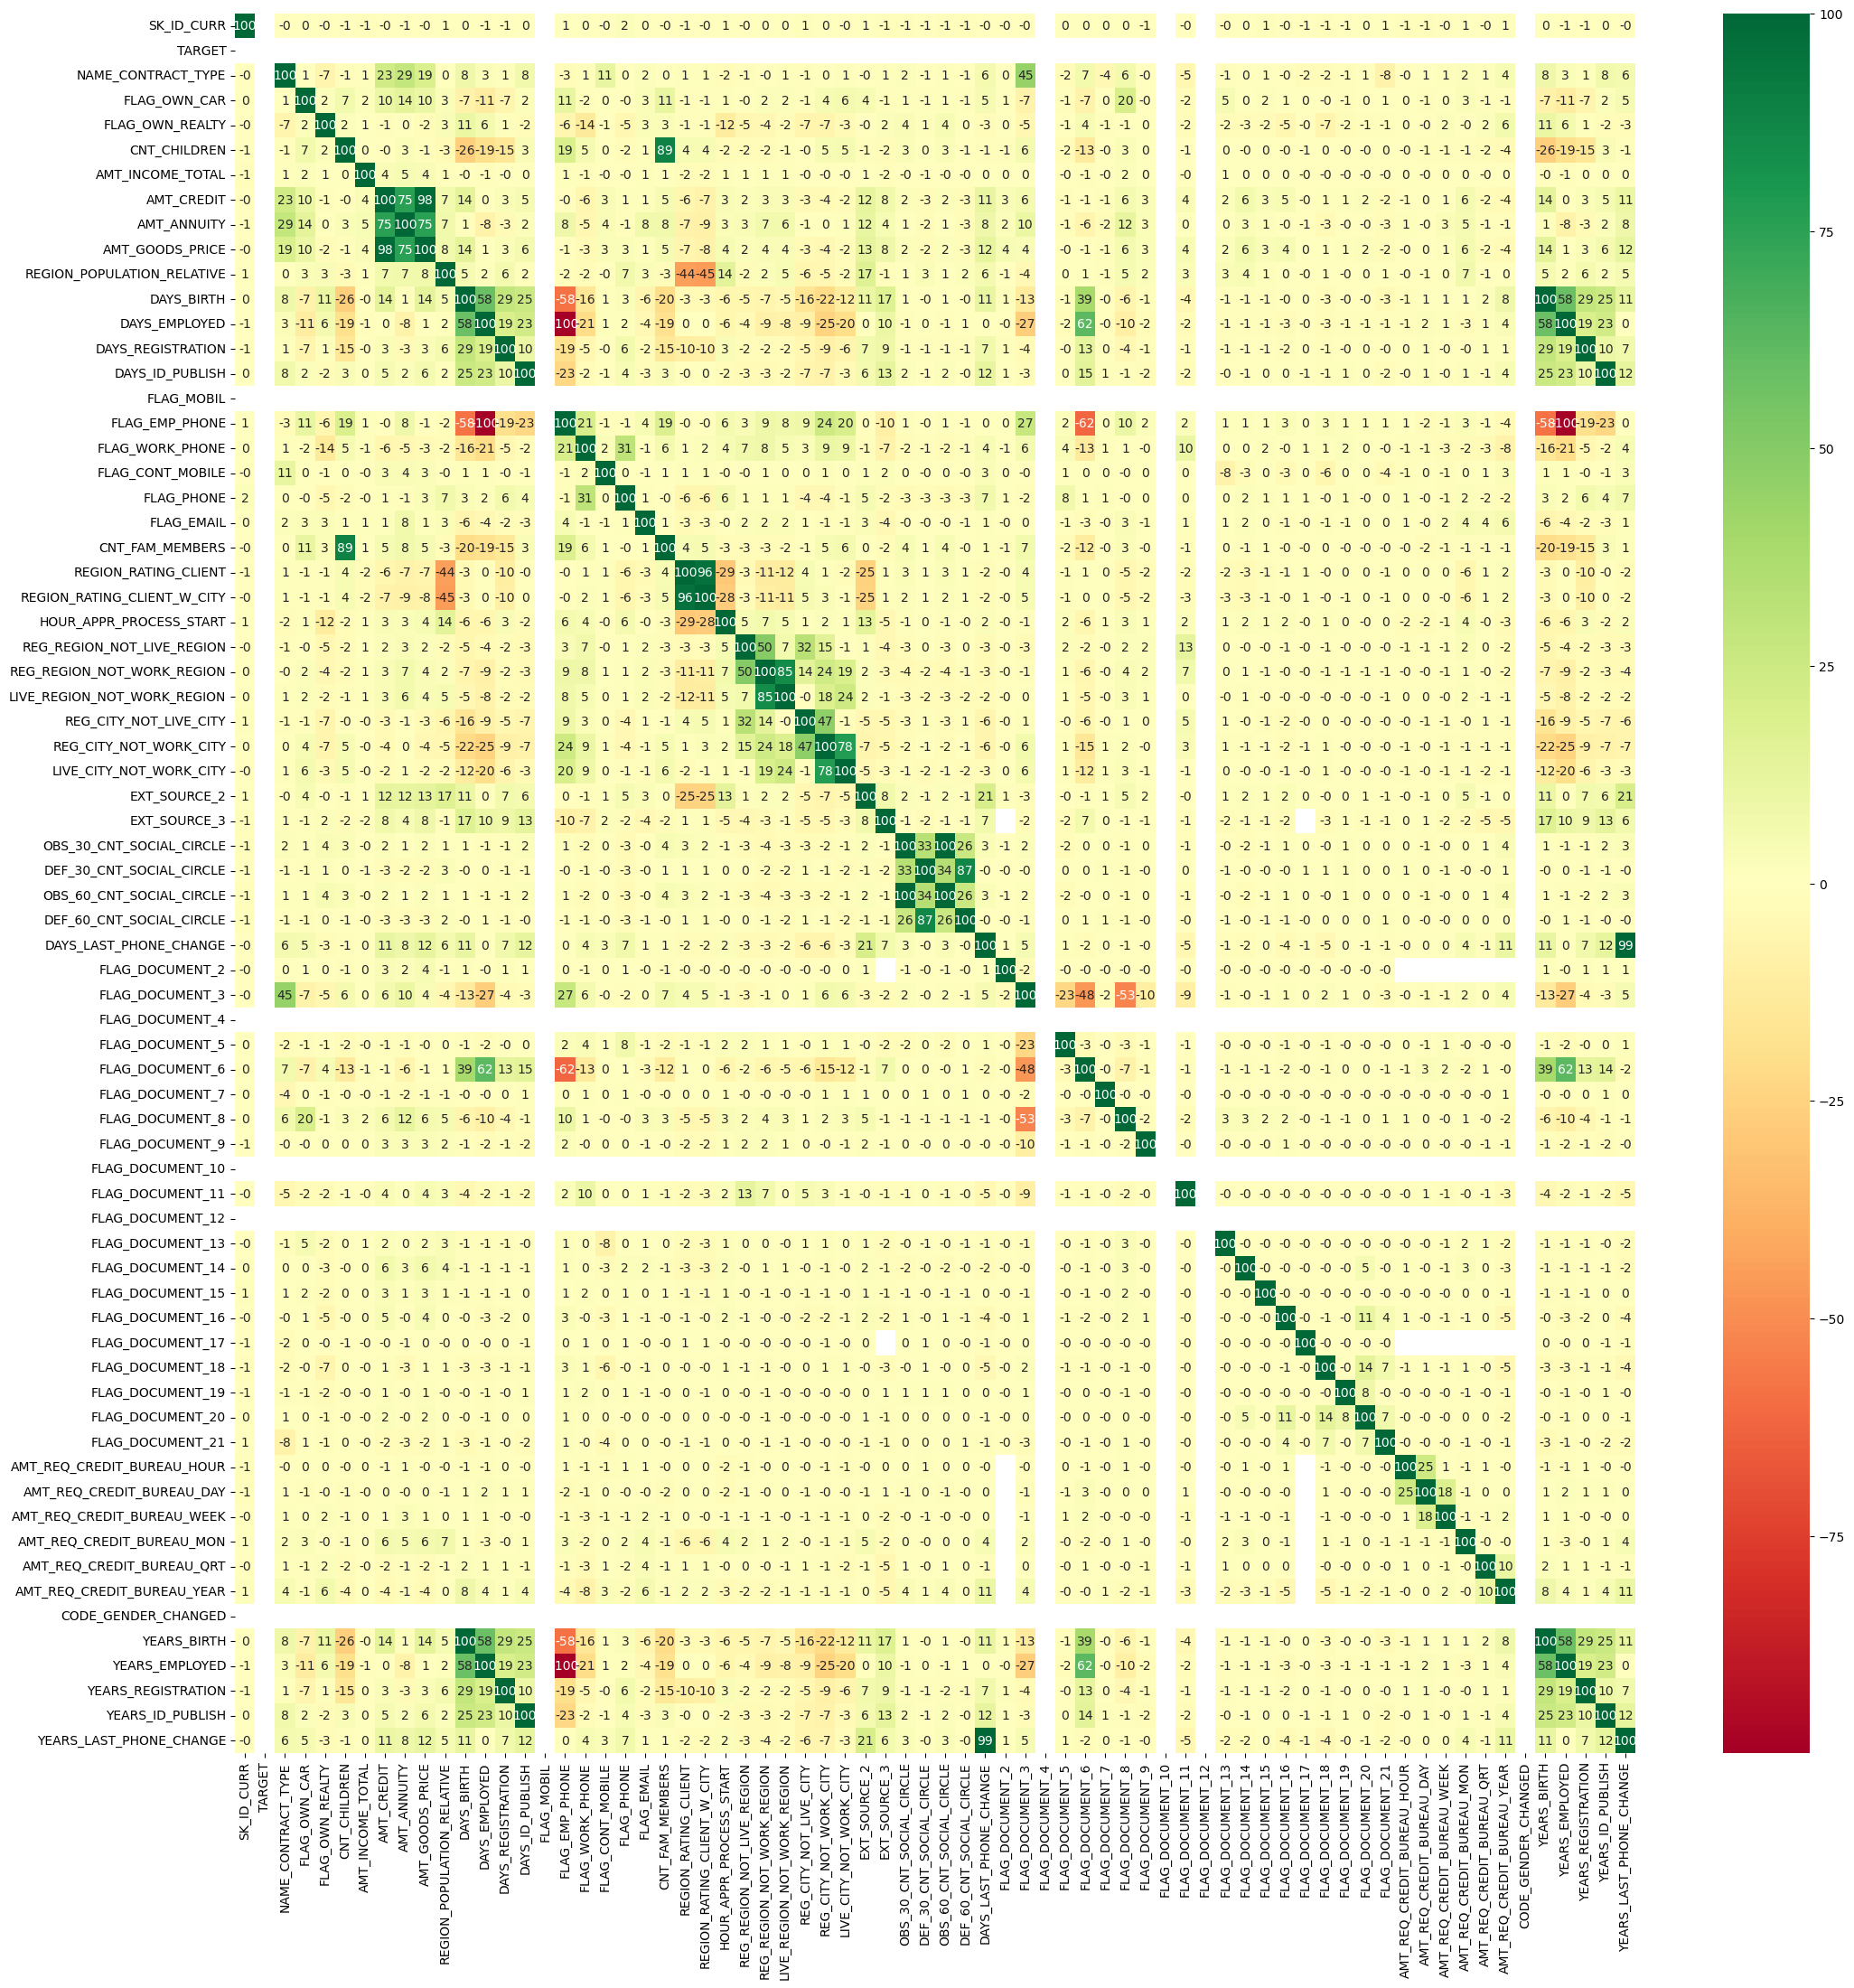

In [195]:
plt.figure(figsize = (25,25))
sns.heatmap(data = corr_df1*100, annot = True, cmap = "RdYlGn", cbar = True, fmt='.0f')
plt.show()

Створимо теплову карту для перегляду кореляцій вище 80% і 99,99%

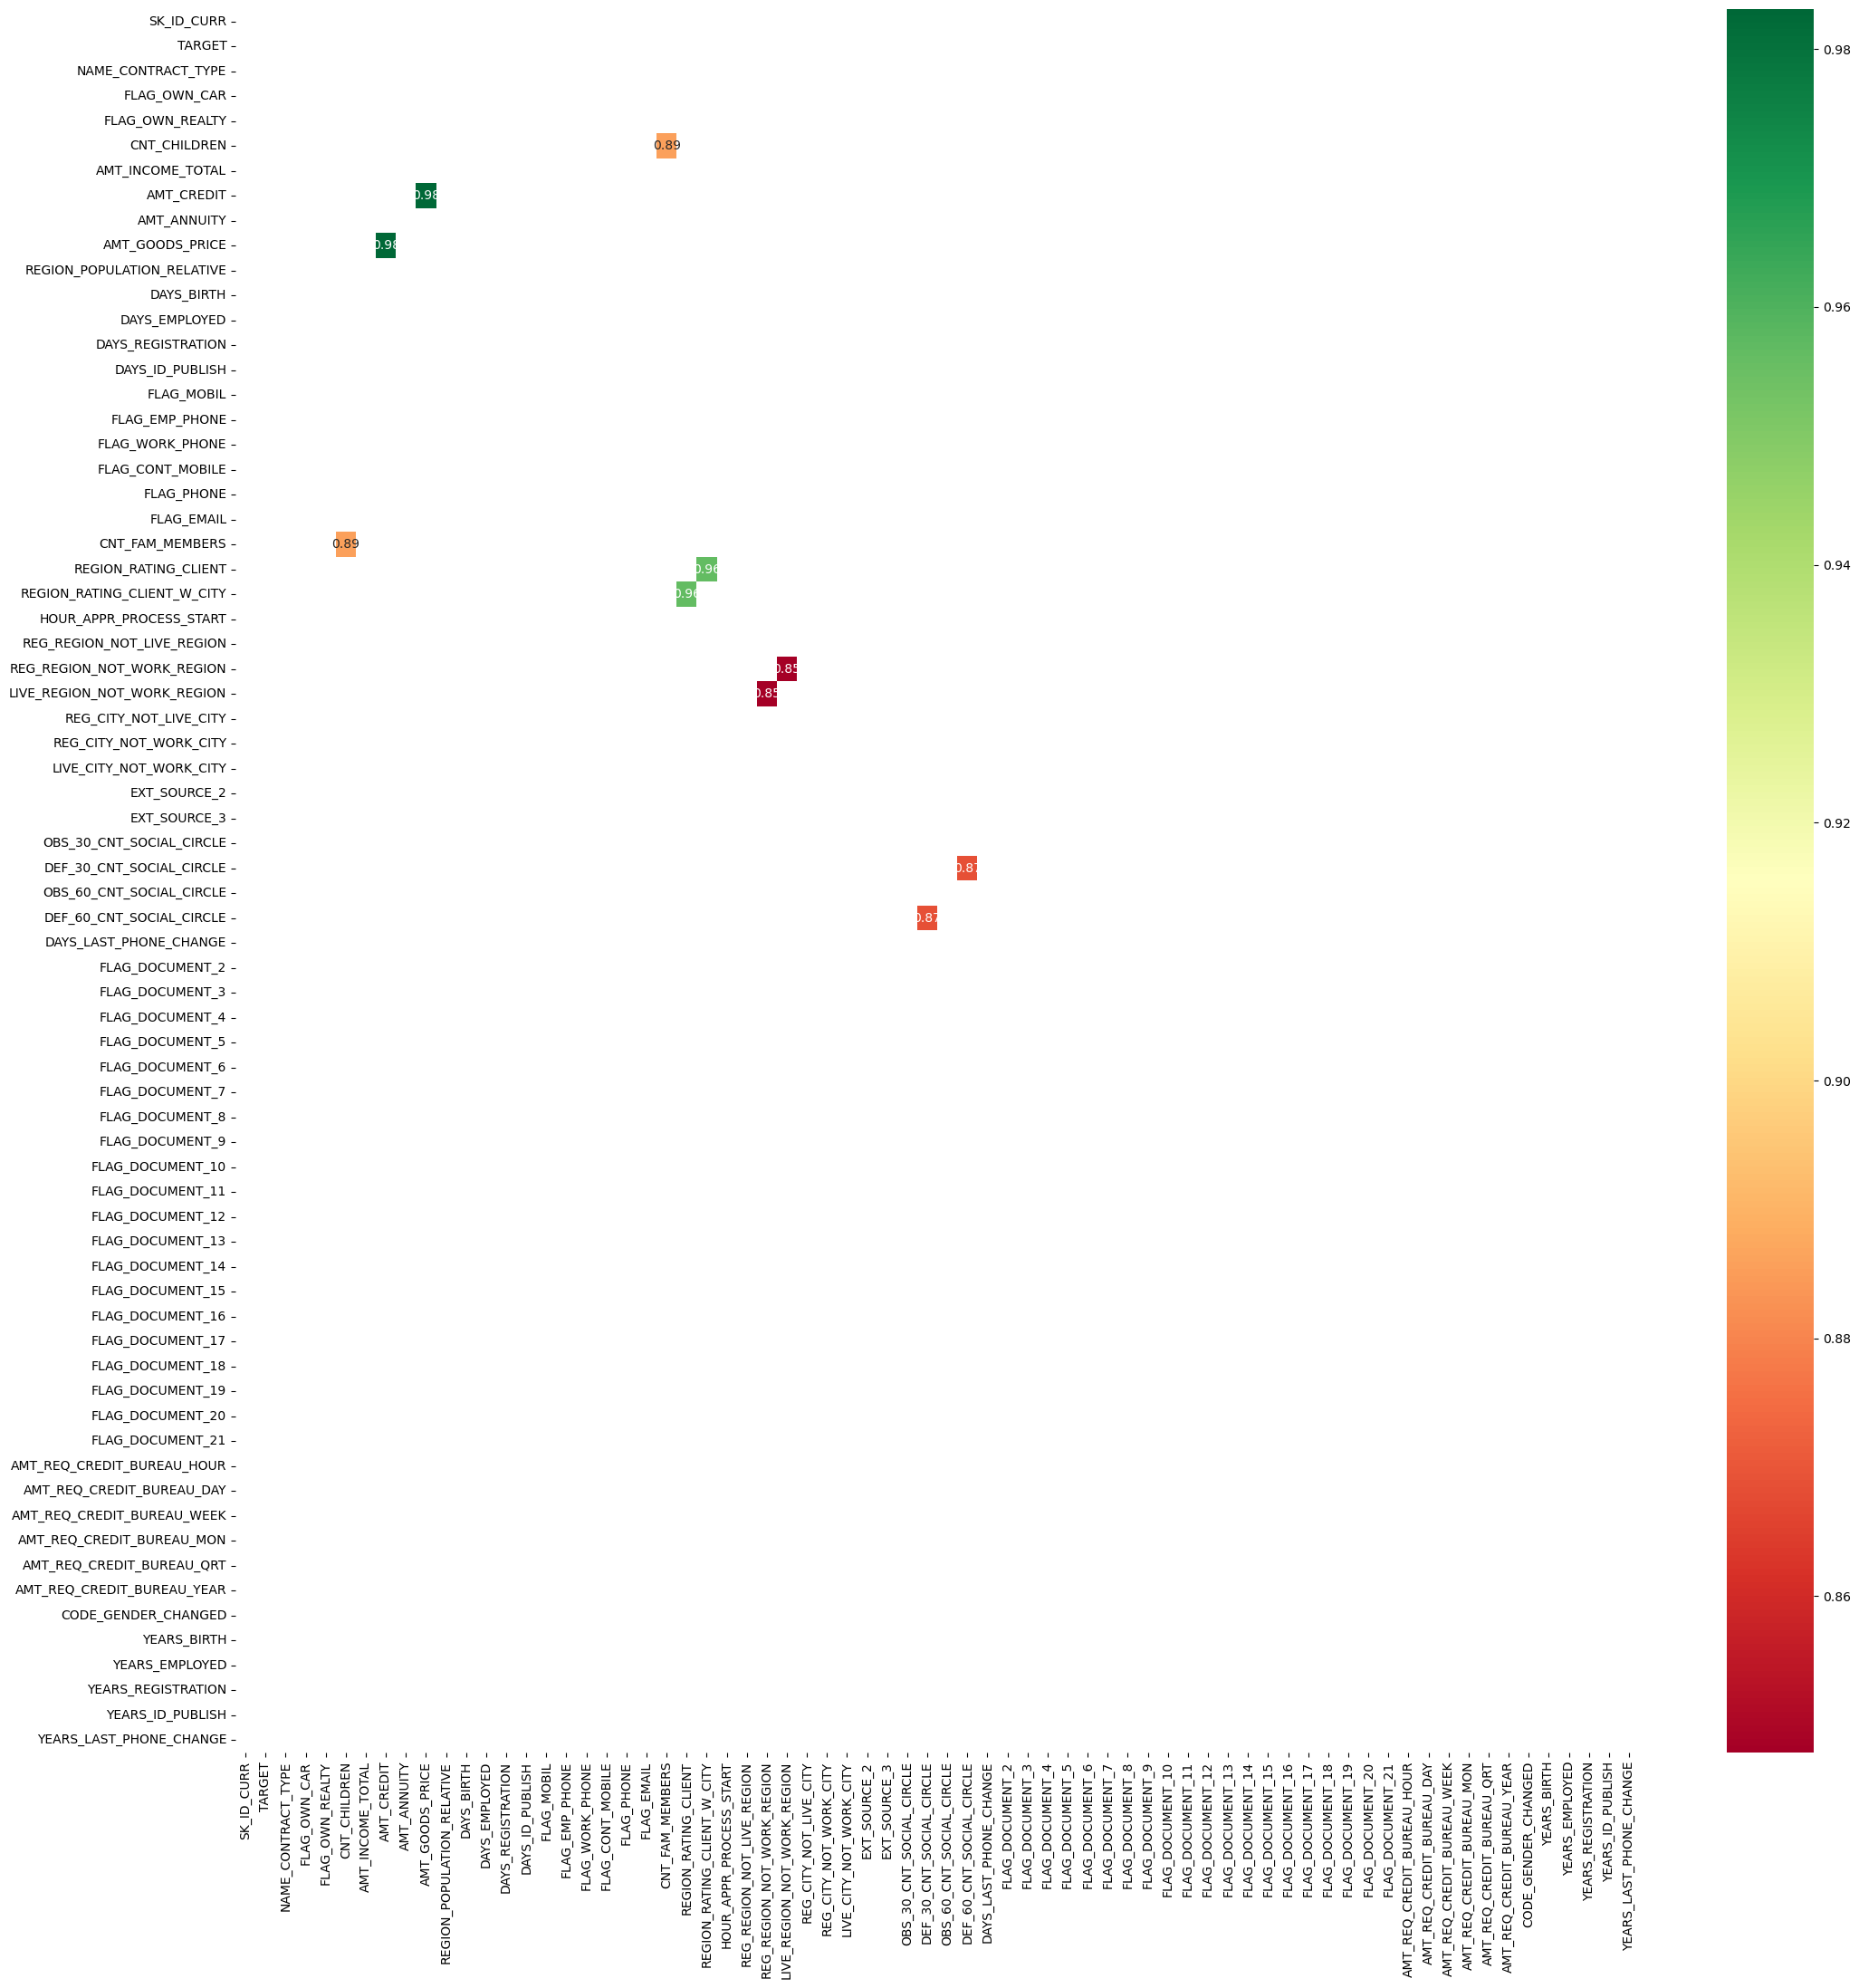

In [196]:
plt.figure(figsize = (25,25))
sns.heatmap(data = corr_df1[(corr_df1 >= 0.8) & (corr_df1 < 0.99)], annot = True, cmap = "RdYlGn", cbar = True, fmt='.2f')
plt.show()

### Подивимось на 10 найкращих кореляцій для випадків із платіжними труднощами

In [197]:
corr_df1[corr_df1 <= 0.99].unstack().sort_values(ascending = False).head(22)

AMT_CREDIT                   AMT_GOODS_PRICE               0.98
AMT_GOODS_PRICE              AMT_CREDIT                    0.98
REGION_RATING_CLIENT_W_CITY  REGION_RATING_CLIENT          0.96
REGION_RATING_CLIENT         REGION_RATING_CLIENT_W_CITY   0.96
CNT_FAM_MEMBERS              CNT_CHILDREN                  0.89
CNT_CHILDREN                 CNT_FAM_MEMBERS               0.89
DEF_30_CNT_SOCIAL_CIRCLE     DEF_60_CNT_SOCIAL_CIRCLE      0.87
DEF_60_CNT_SOCIAL_CIRCLE     DEF_30_CNT_SOCIAL_CIRCLE      0.87
LIVE_REGION_NOT_WORK_REGION  REG_REGION_NOT_WORK_REGION    0.85
REG_REGION_NOT_WORK_REGION   LIVE_REGION_NOT_WORK_REGION   0.85
REG_CITY_NOT_WORK_CITY       LIVE_CITY_NOT_WORK_CITY       0.78
LIVE_CITY_NOT_WORK_CITY      REG_CITY_NOT_WORK_CITY        0.78
AMT_GOODS_PRICE              AMT_ANNUITY                   0.75
AMT_ANNUITY                  AMT_GOODS_PRICE               0.75
                             AMT_CREDIT                    0.75
AMT_CREDIT                   AMT_ANNUITY

Оскільки у нас є комбінації, що повторюються, дивлячись на наведену вище таблицю і видаляючи дублі, ми отримуємо топ-10 кореляцій, як показано нижче:

- AMT_GOODS_PRICE -              AMT_CREDIT                    0.98
- REGION_RATING_CLIENT -         REGION_RATING_CLIENT_W_CITY   0.96
- CNT_FAM_MEMBERS -              CNT_CHILDREN                  0.89
- DEF_60_CNT_SOCIAL_CIRCLE -     DEF_30_CNT_SOCIAL_CIRCLE      0.87
- REG_REGION_NOT_WORK_REGION -   LIVE_REGION_NOT_WORK_REGION   0.85
- LIVE_CITY_NOT_WORK_CITY -      REG_CITY_NOT_WORK_CITY        0.78
- AMT_ANNUITY -                  AMT_GOODS_PRICE               0.75
- AMT_ANNUITY -                  AMT_CREDIT                    0.75
- DAYS_EMPLOYED -                FLAG_DOCUMENT_6               0.62
- DAYS_BIRTH -                   DAYS_EMPLOYED                 0.58

### Побудова кореляційної матриці для випадків із вчасними платежеми

In [198]:
df0.select_dtypes(include='number').shape

(282686, 70)

Є 67 числових стовпчиків. Створимо кореляційну матрицю `corr` для кращого перегляду результатів

In [199]:
corr_df0 = df0.select_dtypes(include='number').corr()

In [200]:
corr_df0.head()

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  FLAG_OWN_CAR  \
SK_ID_CURR                1.00     NaN               -0.00          0.00   
TARGET                     NaN     NaN                 NaN           NaN   
NAME_CONTRACT_TYPE       -0.00     NaN                1.00         -0.00   
FLAG_OWN_CAR              0.00     NaN               -0.00          1.00   
FLAG_OWN_REALTY           0.00     NaN               -0.07         -0.01   

                    FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  \
SK_ID_CURR                     0.00         -0.00              0.00   
TARGET                          NaN           NaN               NaN   
NAME_CONTRACT_TYPE            -0.07         -0.03              0.00   
FLAG_OWN_CAR                  -0.01          0.11              0.18   
FLAG_OWN_REALTY                1.00         -0.00              0.00   

                    AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
SK_ID_CURR               -0.00         0.00            -0.00   
TARGET                     NaN          NaN              NaN   
NAME_CONTRACT_TYPE        0.22         0.24             0.19   
FLAG_OWN_CAR              0.12         0.14             0.12   
FLAG_OWN_REALTY          -0.04        -0.01            -0.05   

                    REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
SK_ID_CURR                                0.00        0.00           0.00   
TARGET                                     NaN         NaN            NaN   
NAME_CONTRACT_TYPE                       -0.03        0.09           0.06   
FLAG_OWN_CAR                              0.04       -0.14          -0.16   
FLAG_OWN_REALTY                           0.01        0.12           0.07   

                    DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  \
SK_ID_CURR                       0.00             0.00        0.00   
TARGET                            NaN              NaN         NaN   
NAME_CONTRACT_TYPE               0.02             0.05       -0.00   
FLAG_OWN_CAR                    -0.09            -0.02       -0.00   
FLAG_OWN_REALTY                  0.03            -0.01       -0.00   

                    FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  \
SK_ID_CURR                   -0.00            -0.00              0.00   
TARGET                         NaN              NaN               NaN   
NAME_CONTRACT_TYPE           -0.06             0.03              0.10   
FLAG_OWN_CAR                  0.16             0.01             -0.01   
FLAG_OWN_REALTY              -0.07            -0.11              0.01   

                    FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
SK_ID_CURR                0.00        0.00            -0.00   
TARGET                     NaN         NaN              NaN   
NAME_CONTRACT_TYPE        0.02        0.01            -0.01   
FLAG_OWN_CAR             -0.01        0.03             0.15   
FLAG_OWN_REALTY          -0.04        0.03             0.01   

                    REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
SK_ID_CURR                         -0.00                        -0.00   
TARGET                               NaN                          NaN   
NAME_CONTRACT_TYPE                  0.02                         0.02   
FLAG_OWN_CAR                       -0.02                        -0.02   
FLAG_OWN_REALTY                     0.00                         0.00   

                    HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
SK_ID_CURR                            -0.00                        0.00   
TARGET                                  NaN                         NaN   
NAME_CONTRACT_TYPE                    -0.04                       -0.02   
FLAG_OWN_CAR                           0.01                       -0.00   
FLAG_OWN_REALTY                       -0.10                       -0.03   

                    REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
SK_ID_CURR                                0.00                         0.00   
T

Створимо теплову карту для перегляду кореляцій вище 80% і 99,99%

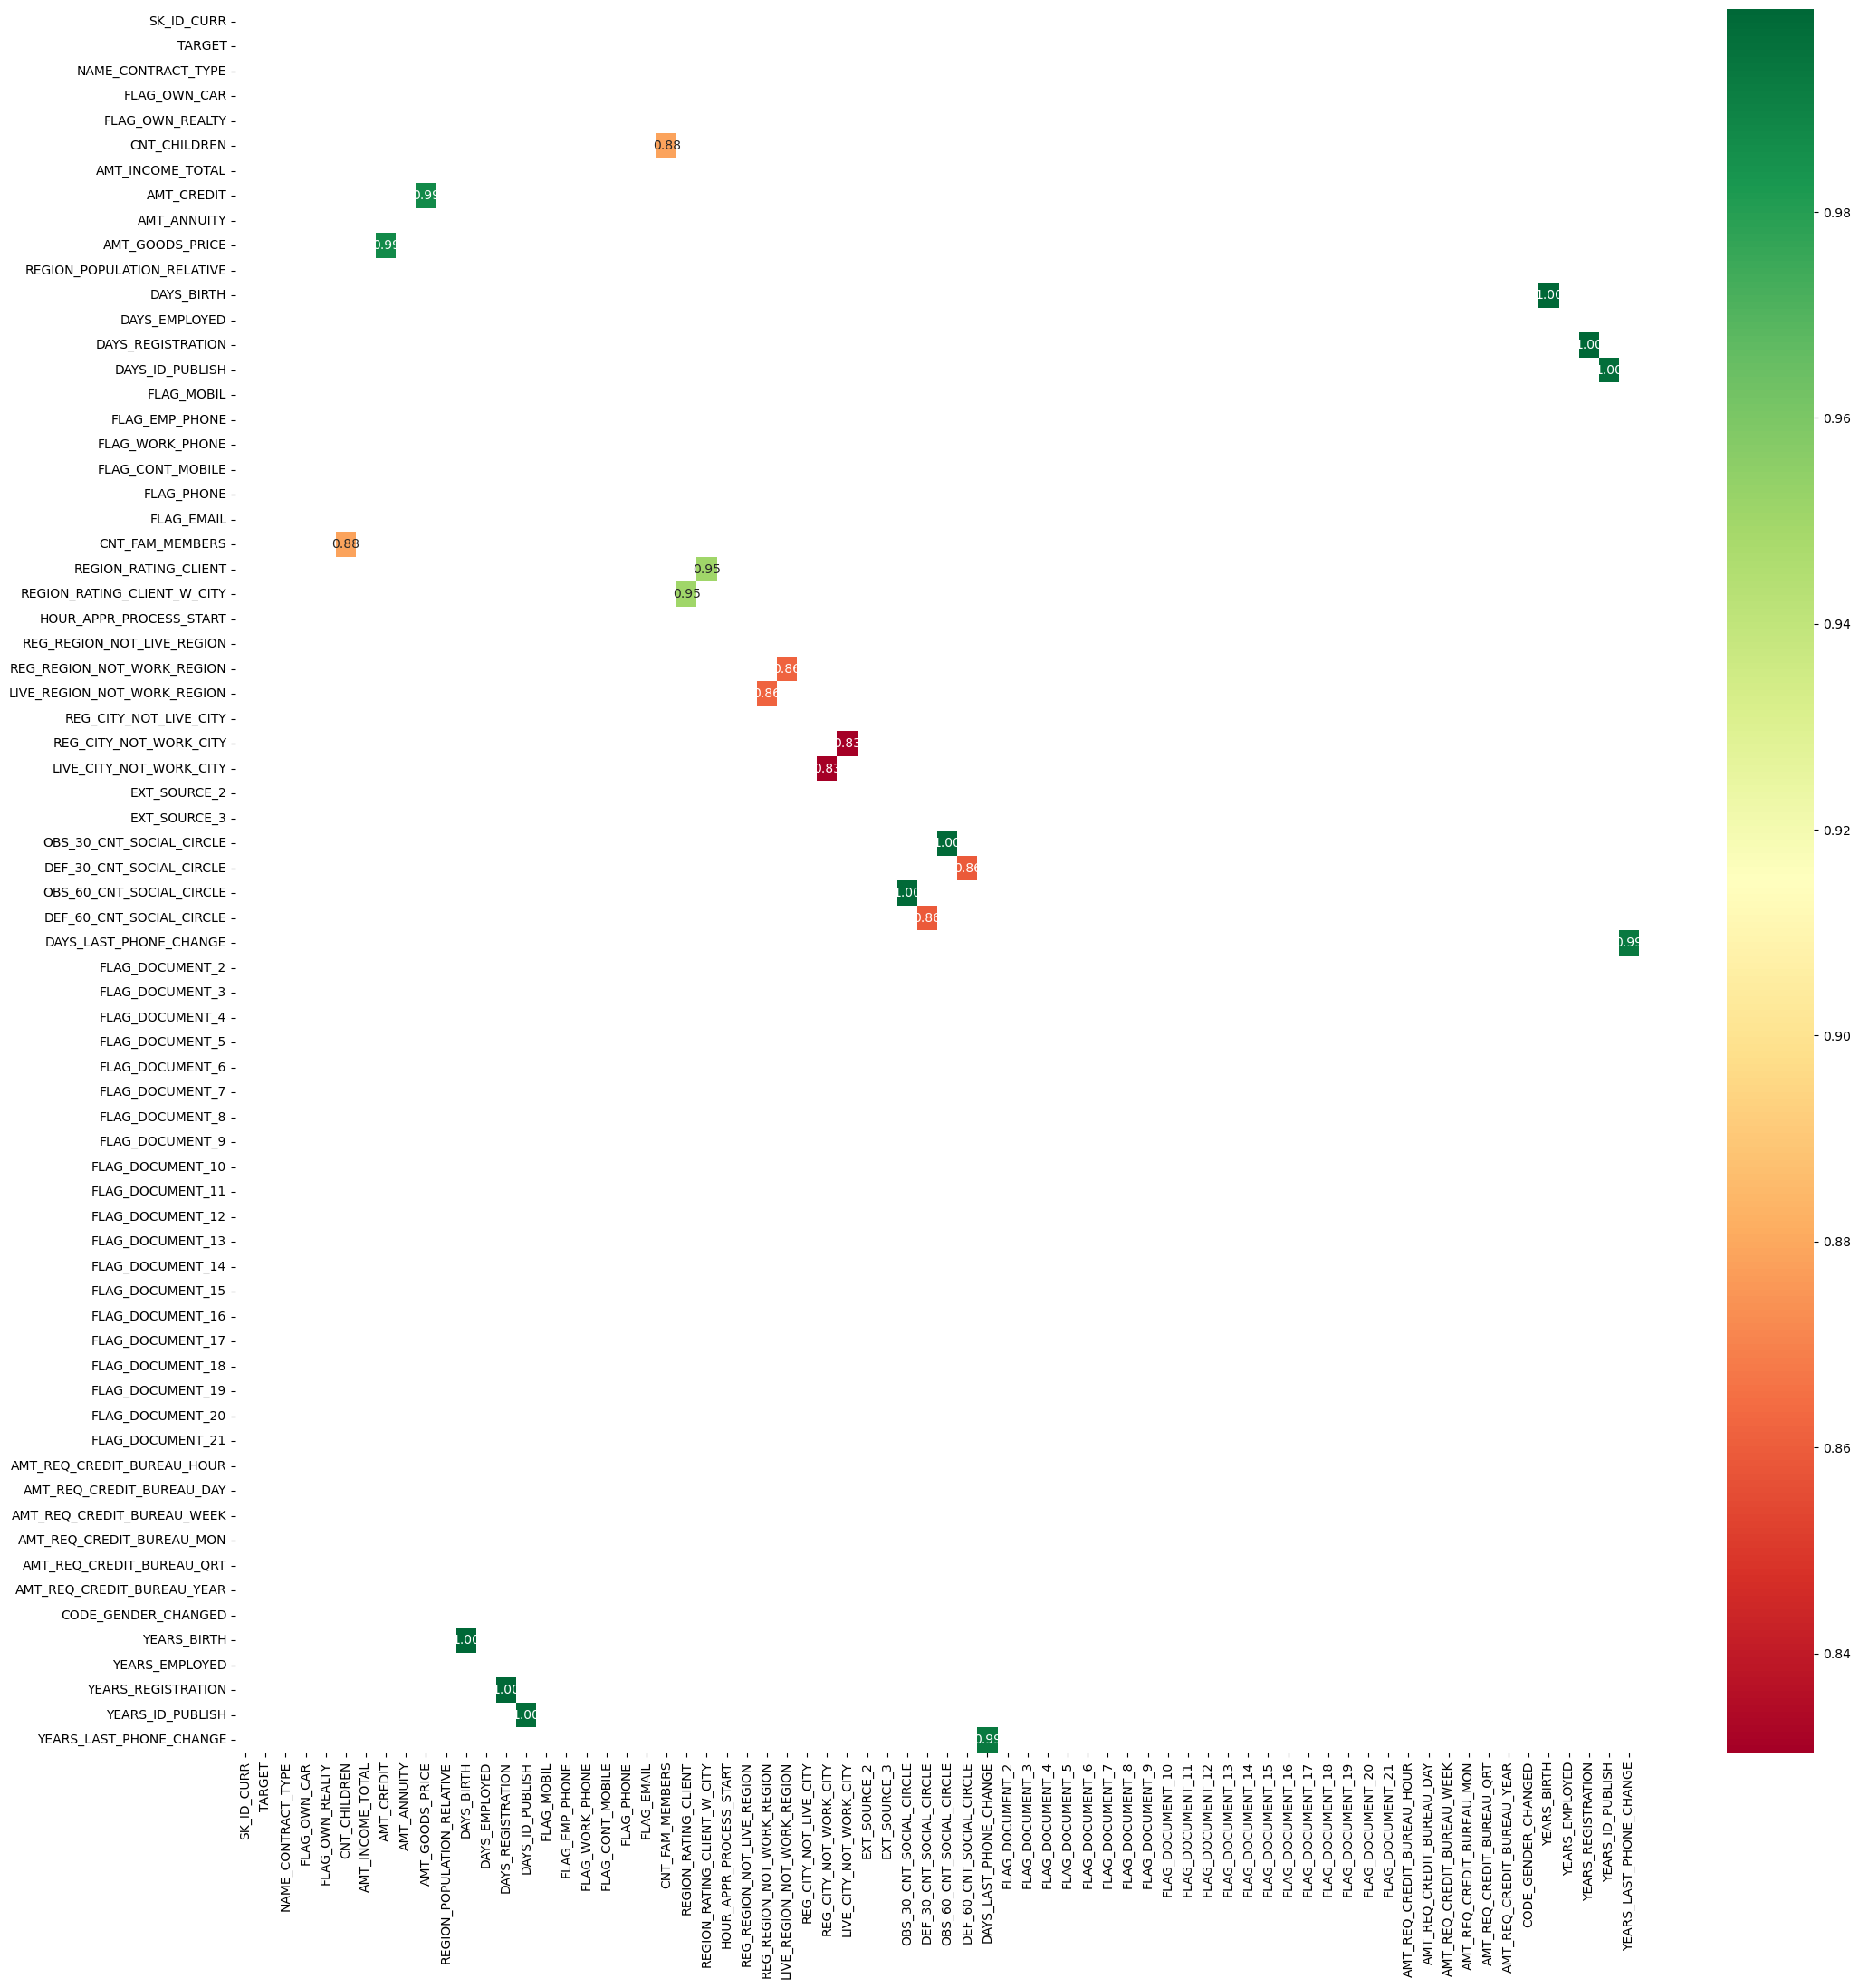

In [201]:
plt.figure(figsize = (25,25))
sns.heatmap(data = corr_df0[(corr_df0 >= 0.8) & (corr_df0 < 0.9999)], annot = True, cmap = "RdYlGn", cbar = True, fmt='.2f')
plt.show()

### Подивимось на 10 найкращих кореляцій для вчасних платежів

In [202]:
corr_df0[corr_df0 <= 0.99].unstack().sort_values(ascending = False).head(28)

AMT_CREDIT                   AMT_GOODS_PRICE               0.99
AMT_GOODS_PRICE              AMT_CREDIT                    0.99
REGION_RATING_CLIENT_W_CITY  REGION_RATING_CLIENT          0.95
REGION_RATING_CLIENT         REGION_RATING_CLIENT_W_CITY   0.95
CNT_CHILDREN                 CNT_FAM_MEMBERS               0.88
CNT_FAM_MEMBERS              CNT_CHILDREN                  0.88
LIVE_REGION_NOT_WORK_REGION  REG_REGION_NOT_WORK_REGION    0.86
REG_REGION_NOT_WORK_REGION   LIVE_REGION_NOT_WORK_REGION   0.86
DEF_30_CNT_SOCIAL_CIRCLE     DEF_60_CNT_SOCIAL_CIRCLE      0.86
DEF_60_CNT_SOCIAL_CIRCLE     DEF_30_CNT_SOCIAL_CIRCLE      0.86
REG_CITY_NOT_WORK_CITY       LIVE_CITY_NOT_WORK_CITY       0.83
LIVE_CITY_NOT_WORK_CITY      REG_CITY_NOT_WORK_CITY        0.83
AMT_GOODS_PRICE              AMT_ANNUITY                   0.78
AMT_ANNUITY                  AMT_GOODS_PRICE               0.78
                             AMT_CREDIT                    0.77
AMT_CREDIT                   AMT_ANNUITY

Оскільки у нас є комбінації, що повторюються, дивлячись на наведену вище таблицю і видаляючи дублі, ми отримуємо топ-10 кореляцій, як показано нижче:

- AMT_GOODS_PRICE              AMT_CREDIT                    0.99
- REGION_RATING_CLIENT         REGION_RATING_CLIENT_W_CITY   0.95
- CNT_FAM_MEMBERS              CNT_CHILDREN                  0.88
- REG_REGION_NOT_WORK_REGION   LIVE_REGION_NOT_WORK_REGION   0.86
- DEF_30_CNT_SOCIAL_CIRCLE     DEF_60_CNT_SOCIAL_CIRCLE      0.86
- LIVE_CITY_NOT_WORK_CITY      REG_CITY_NOT_WORK_CITY        0.83
- AMT_ANNUITY                  AMT_GOODS_PRICE               0.78
- AMT_ANNUITY                  AMT_CREDIT                    0.77
- DAYS_BIRTH                   DAYS_EMPLOYED                 0.63
- DAYS_EMPLOYED                FLAG_DOCUMENT_6               0.60

### Порівняємо 10 найкращих кореляцій між випадками із платіжними труднощами та вчасними платежами

**Спостереження**

- Топ-10 кореляцій для Труднощів з оплатою та Вчасних платежів однакові, за винятком незначних відмінностей у відсотках кореляції
- Найвища кореляція для комбінації `AMT_GOODS_PRICE` та `AMT_CREDIT`.
- Для набору даних "Труднощі з оплатою" кореляція між `AMT_GOODS_PRICE` та `AMT_CREDIT` становить 0,98
- Для набору даних "Вчасні платежі" кореляція між `AMT_GOODS_PRICE` та `AMT_CREDIT` становить 0,99

**Custom logic: 8** - create first correlation related method and pyton files for statistic and visualization

In [ ]:
# import importlib
# import mlpeople.visualization.relationships.correlation as v_correlation
# importlib.reload(v_correlation)

from mlpeople.visualization.relationships.correlation import (
    show_correlation_matrix_filtered,
    show_correlation_matrix_filtered_static
)

# import importlib
# import mlpeople.statistic.correlation as s_correlation
# importlib.reload(s_correlation)

from mlpeople.statistic.correlation import get_correlation_details_filtered

In [211]:
get_correlation_details_filtered(df, upper_abs_threshold=0.99).head()

Feature_1                    Feature_2  Correlation
0              AMT_GOODS_PRICE                   AMT_CREDIT         0.99
1                   AMT_CREDIT              AMT_GOODS_PRICE         0.99
2  REGION_RATING_CLIENT_W_CITY         REGION_RATING_CLIENT         0.95
3         REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY         0.95
4              CNT_FAM_MEMBERS                 CNT_CHILDREN         0.88

In [207]:
get_correlation_details_filtered(df, abs_threshold=0.05, target_feature='TARGET')

Feature_1                    Feature_2  Correlation
0     TARGET                 EXT_SOURCE_3        -0.18
1     TARGET                 EXT_SOURCE_2        -0.16
2     TARGET                  YEARS_BIRTH        -0.08
3     TARGET                   DAYS_BIRTH        -0.08
4     TARGET  REGION_RATING_CLIENT_W_CITY         0.06
5     TARGET         REGION_RATING_CLIENT         0.06
6     TARGET       DAYS_LAST_PHONE_CHANGE        -0.06
7     TARGET      YEARS_LAST_PHONE_CHANGE        -0.05
8     TARGET              DAYS_ID_PUBLISH        -0.05
9     TARGET             YEARS_ID_PUBLISH        -0.05
10    TARGET       REG_CITY_NOT_WORK_CITY         0.05

In [212]:
show_correlation_matrix_filtered(df)

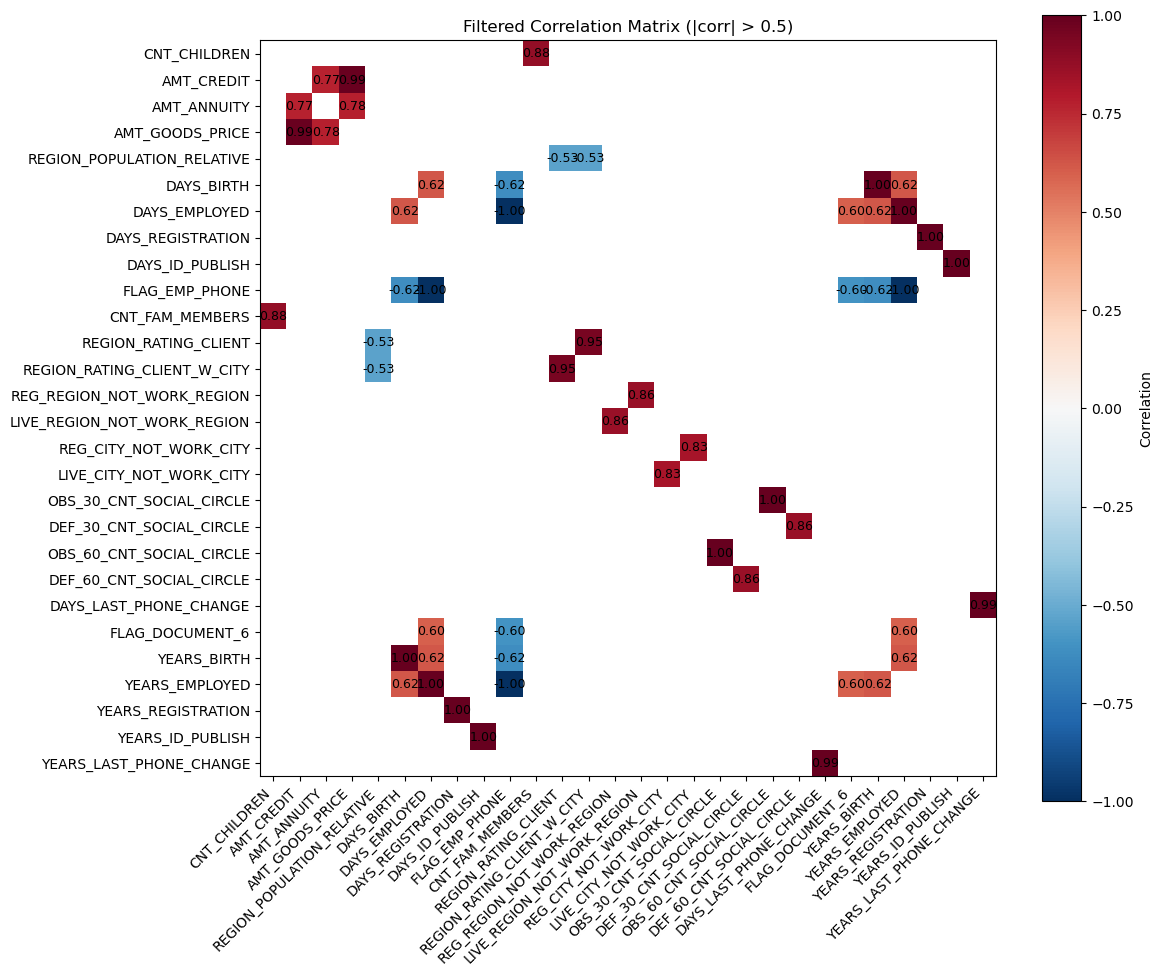

In [218]:
show_correlation_matrix_filtered_static(df)

# Одновимірний аналіз числових змінних

### Аналіз стовпця `AMT_CREDIT`

#### Пошук викидів в `AMT_CREDIT` при випадках із платіжними труднощами

Розрахунок IQR (Inter Quartile range)

In [219]:
Q1 = df1['AMT_CREDIT'].quantile(0.25)
Q3 = df1['AMT_CREDIT'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

448915.5


Значення *до* (Q1 - 1.5 * IQR) та *після* (Q3 + 1.5 * IQR) є викидами.

In [220]:
Min_value1 = (Q1 - 1.5 * IQR)
Max_value1 = (Q3 + 1.5 * IQR)
print("Мінімальне значення, до якого існують викиди: {}".format(Min_value1))
print("Максимальне значення, після якого існують викиди: {}".format(Max_value1))

Мінімальне значення, до якого існують викиди: -388973.25
Максимальне значення, після якого існують викиди: 1406688.75


#### Пошук викидів в `AMT_CREDIT` при випадках із вчасними оплатами

Розрахунок IQR (Inter Quartile range)

In [221]:
Q1 = df0['AMT_CREDIT'].quantile(0.25)
Q3 = df0['AMT_CREDIT'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

540000.0


Значення *до* (Q1 - 1.5 * IQR) та *після* (Q3 + 1.5 * IQR) є викидами.

In [222]:
Min_value0 = (Q1 - 1.5 * IQR)
Max_value0 = (Q3 + 1.5 * IQR)
print("Мінімальне значення, до якого існують викиди: {}".format(Min_value0))
print("Максимальне значення, після якого існують викиди: {}".format(Max_value0))

Мінімальне значення, до якого існують викиди: -540000.0
Максимальне значення, після якого існують викиди: 1620000.0


Видалення викидів і побудова діаграми розподілу

In [223]:
def kde_no_outliers(df0, df1, Max_value0, Max_value1, column):
  plt.figure(figsize = (14,6))
  sns.kdeplot(df1[df1[column] <= Max_value1][column],label = 'Payment difficulties')
  sns.kdeplot(df0[df0[column] <= Max_value0][column],label = 'On-Time Payments')
  plt.ticklabel_format(style='plain', axis='x')
  plt.xticks(rotation = 45)
  plt.legend()
  plt.show()

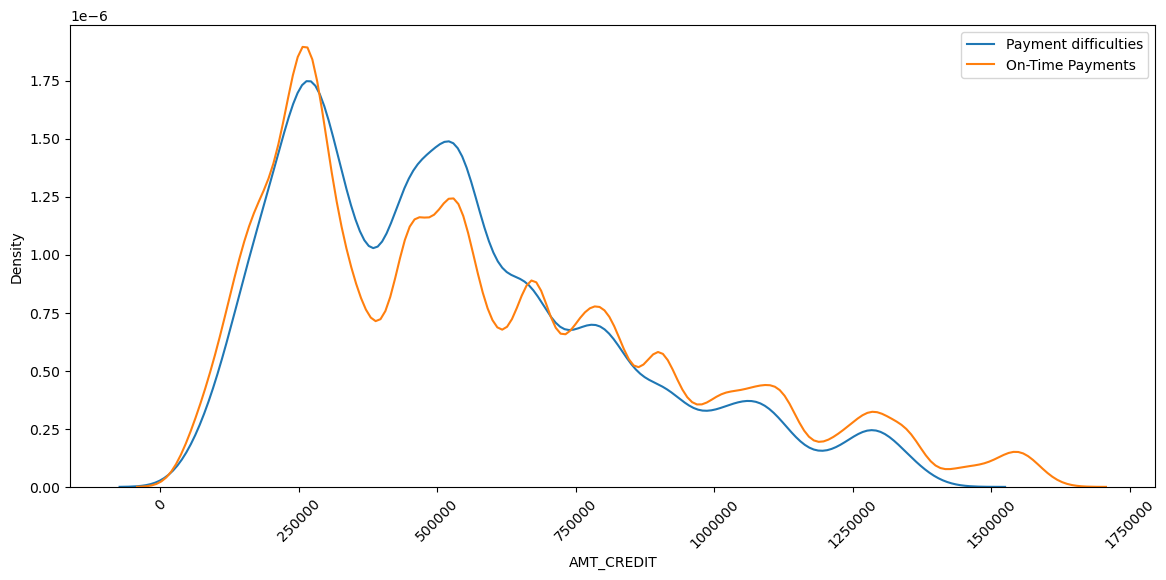

In [224]:
kde_no_outliers(df0, df1, Max_value0, Max_value1, 'AMT_CREDIT')

**Спостереження**

- Для `AMT_CREDIT` від 250000 до приблизно 650000 більше клієнтів мають труднощі з оплатою
- Для `AMT_CREDIT` > 750000 більше клієнтів, які вчасно здійснюють платежі

**Custom logic: 9** - create src logic for kde plots

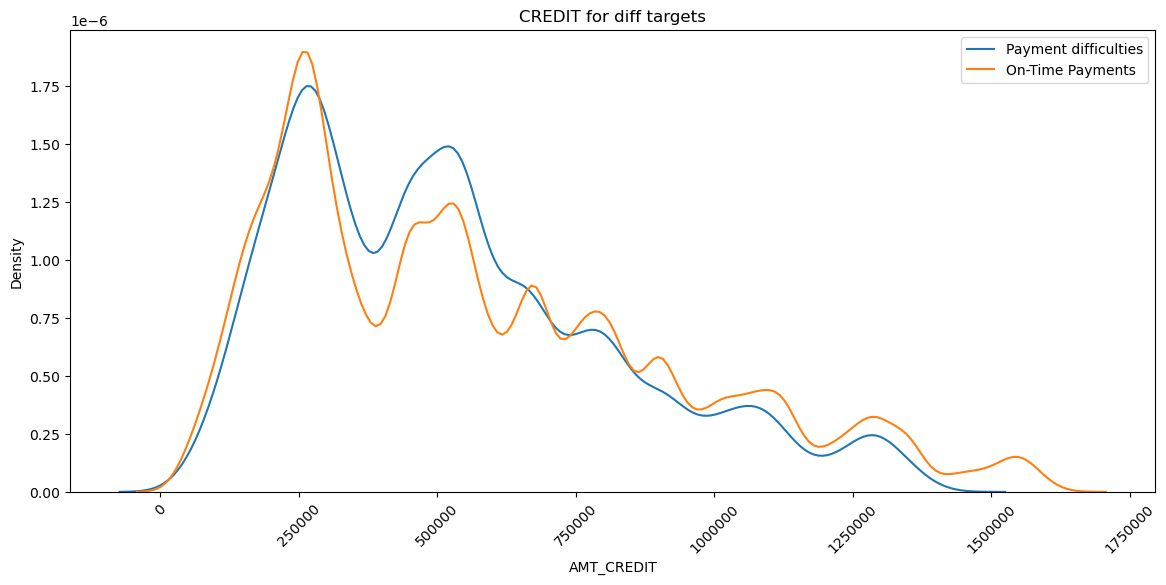

In [225]:
from mlpeople.visualization.distributions.kde import kde_plot

kde_plot(
    df, 'AMT_CREDIT',
    target_col='TARGET',
    drop_outliers=True,
    title='CREDIT for diff targets',
    labels={
        1: 'Payment difficulties',
        0: 'On-Time Payments'
    }
)

# Двовимірний/Багатовимірний аналіз

## Неперервні vs неперервні змінні

### Аналіз стовпця `AMT_GOODS_PRICE` vs `AMT_CREDIT`

**Пошук викидів для ствопця `AMT_GOODS_PRICE ` для групи із платіжними труднощами**

In [226]:
max_value1_AMT_GOODS_PRICE = outlier_range(df1,'AMT_GOODS_PRICE')
max_value1_AMT_GOODS_PRICE

np.float64(1329750.0)

**Пошук викидів для ствопця `AMT_CREDIT` для групи із платіжними труднощами**

In [227]:
max_value1_AMT_CREDIT = outlier_range(df1,'AMT_CREDIT')
max_value1_AMT_CREDIT

np.float64(1406688.75)

**Пошук викидів для `AMT_GOODS_PRICE `для групи із вчасними оплатами**

In [228]:
max_value0_AMT_GOODS_PRICE = outlier_range(df0,'AMT_GOODS_PRICE')
max_value0_AMT_GOODS_PRICE

np.float64(1363500.0)

**Пошук викидів для `AMT_CREDIT `для групи із вчасними оплатами**

In [229]:
max_value0_AMT_CREDIT = outlier_range(df0,'AMT_CREDIT')
max_value0_AMT_CREDIT

np.float64(1620000.0)

Побудова діаграми розсіювання для порівняння з видаленими викидами

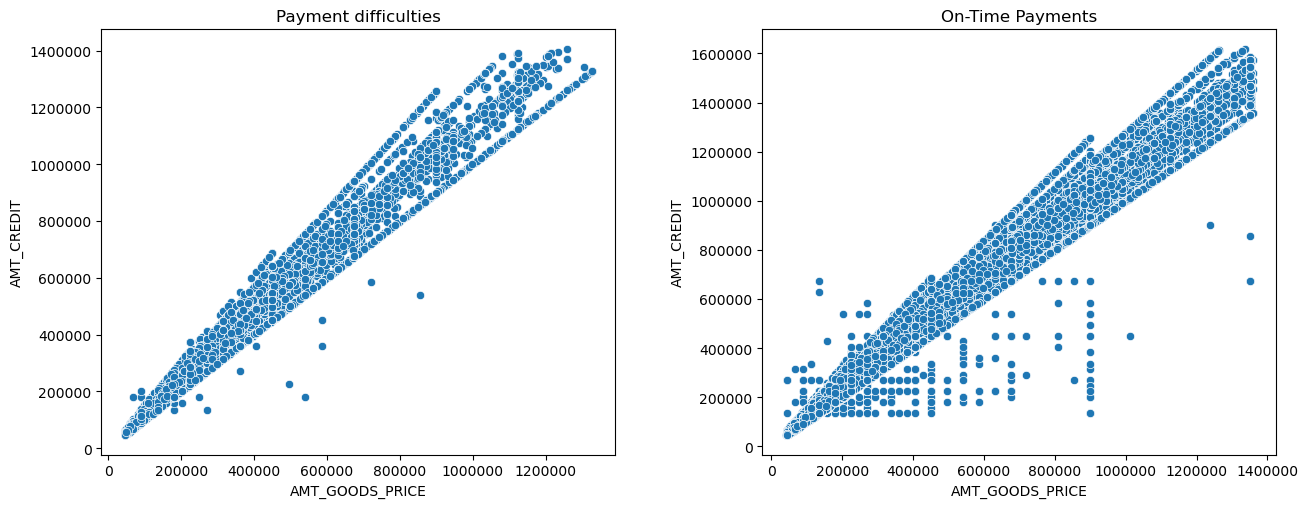

In [230]:
plt.figure(figsize = (14, 6))

plt.subplot(1,2,1)
plt.title('Payment difficulties')
sns.scatterplot(x = df1[df1['AMT_GOODS_PRICE'] < max_value1_AMT_GOODS_PRICE].AMT_GOODS_PRICE,
                y = df1[df1['AMT_CREDIT'] < max_value1_AMT_CREDIT].AMT_CREDIT, data = df1)
plt.ticklabel_format(style='plain', axis='x')
plt.ticklabel_format(style='plain', axis='y')

plt.subplot(1,2,2)
plt.title('On-Time Payments')
sns.scatterplot(x = df0[df0['AMT_GOODS_PRICE'] < max_value0_AMT_GOODS_PRICE].AMT_GOODS_PRICE,
                y = df0[df0['AMT_CREDIT'] < max_value0_AMT_CREDIT].AMT_CREDIT, data = df0)
plt.ticklabel_format(style='plain', axis='x')
plt.ticklabel_format(style='plain', axis='y')

plt.tight_layout(pad = 4)
plt.show()

**Спостереження**
- AMT_GOODS_PRICE та AMT_CREDIT мають сильну позитивну кореляцію. Це означає, що зі збільшенням ціни товару зростає і сума кредиту

**Custom logic: 10** - create src logic for scatter plots

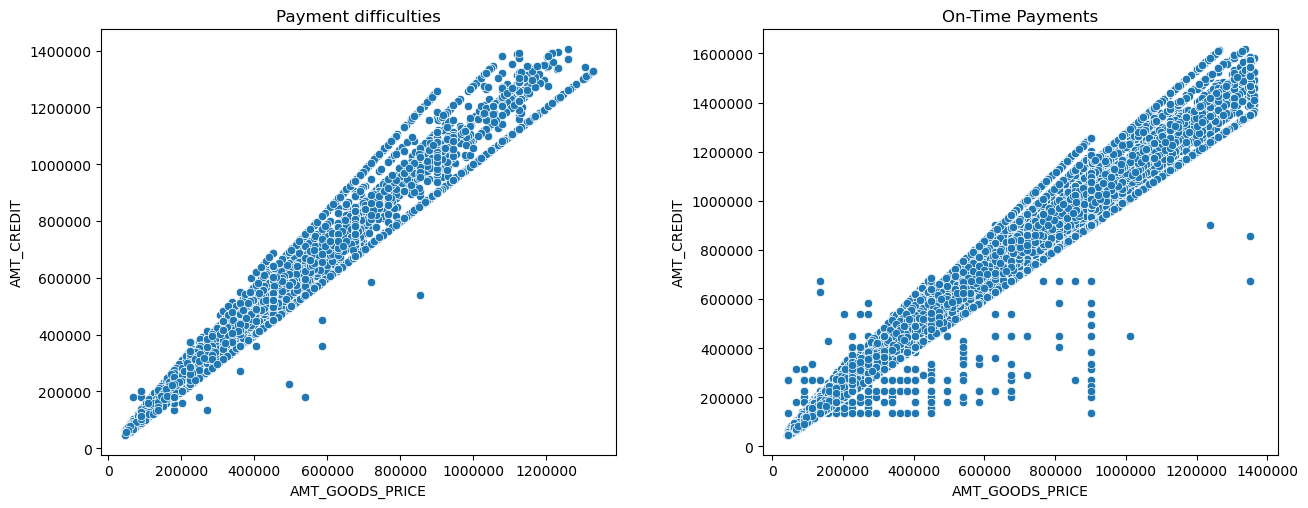

In [231]:
from mlpeople.visualization.relationships.scatter import scatter_compare_by_category

scatter_compare_by_category(
    df,
    col_x='AMT_GOODS_PRICE',
    col_y='AMT_CREDIT',
    target_col='TARGET',
    titles={
        0: 'On-Time Payments',
        1: 'Payment difficulties'
    },
    drop_outliers=True
)

## Неперервні та категоріальні змінні

In [232]:
def draw_boxplot(df, categorical, continuous, max_continuous, title, hue_column, subplot_position):
    """
    Малює блок-діаграму для заданого DataFrame, категоріальної та неперервної змінної.
    """
    plt.subplot(1, 2, subplot_position)
    plt.title(title)
    red_diamond = dict(markerfacecolor='r', marker='D')
    sns.boxplot(x=categorical,
                y=df[df[continuous] < max_continuous][continuous],
                data=df,
                flierprops=red_diamond,
                order=sorted(df[categorical].unique(), reverse=True),
                hue=hue_column, hue_order=sorted(df[hue_column].unique(), reverse=True))
    plt.ticklabel_format(style='plain', axis='y')
    plt.xticks(rotation=90)

def bi_boxplot(categorical, continuous, max_continuous1, max_continuous0, hue_column):
    """
    Створює паралельні блок-діаграми для двох груп, визначених у наборі даних, на основі
    категоріальної та неперервної змінної, виділяючи відмінності за допомогою відтінків.
    """
    plt.figure(figsize=(16, 10))

    # Графік для першо групи "Труднощі з платежами" (Payment Difficulties)
    draw_boxplot(df1, categorical, continuous, max_continuous1, 'Payment Difficulties', hue_column, 1)

    # Графік для другої групи "Вчасні оплати" (On-Time Payments)
    draw_boxplot(df0, categorical, continuous, max_continuous0, 'On-Time Payments', hue_column, 2)

    plt.tight_layout(pad=4)
    plt.show()

### Аналіз стовпців `AMT_CREDIT` vs `NAME_EDUCATION_TYPE` vs `CODE_GENDER`

**Пошук викидів для `AMT_CREDIT `для групи із платіжними труднощами**

In [233]:
max_value1_AMT_CREDIT = outlier_range(df1,'AMT_CREDIT')
max_value1_AMT_CREDIT

np.float64(1406688.75)

**Пошук викидів для `AMT_CREDIT ` для групи із вчасними платежами**

In [234]:
max_value0_AMT_CREDIT = outlier_range(df0,'AMT_CREDIT')
max_value0_AMT_CREDIT

np.float64(1620000.0)

**Клієнт з платіжними труднощами**

In [235]:
df1.groupby(by = ['NAME_EDUCATION_TYPE','CODE_GENDER']).AMT_CREDIT.describe().head()

count      mean       std       min  \
NAME_EDUCATION_TYPE CODE_GENDER                                         
Academic degree     F              3.00 950245.50 504711.38 544491.00   
Higher education    F           2438.00 648500.58 410415.70  47970.00   
                    M           1571.00 642070.94 409695.93  45000.00   
Incomplete higher   F            504.00 520150.35 352227.49  91692.00   
                    M            368.00 554723.82 347843.71  74628.00   

                                      25%       50%        75%        max  
NAME_EDUCATION_TYPE CODE_GENDER                                            
Academic degree     F           667660.50 790830.00 1153122.75 1515415.50  
Higher education    F           323595.00 545040.00  877500.00 2687355.00  
                    M           329202.00 545040.00  832797.00 2695500.00  
Incomplete higher   F           269550.00 450000.00  675000.00 2695500.00  
                    M           284400.00 497520.00  699976.12 2013840.00

**Клієнт зі вчасними платежами**

In [236]:
df0.groupby(by = ['NAME_EDUCATION_TYPE','CODE_GENDER']).AMT_CREDIT.describe().head()

count      mean       std       min  \
NAME_EDUCATION_TYPE CODE_GENDER                                          
Academic degree     F              97.00 708770.74 463052.42 130824.00   
                    M              64.00 735235.38 497739.97  74182.50   
Higher education    F           47852.00 682485.00 456642.78  45000.00   
                    M           23002.00 713144.54 486073.66  45000.00   
Incomplete higher   F            5780.00 555340.53 385980.60  45000.00   

                                      25%       50%        75%        max  
NAME_EDUCATION_TYPE CODE_GENDER                                            
Academic degree     F           354469.50 607500.00 1006920.00 2463840.00  
                    M           309519.00 610056.00 1036890.00 1984500.00  
Higher education    F           302206.50 568057.50  916470.00 4050000.00  
                    M           315000.00 592560.00  973503.00 4050000.00  
Incomplete higher   F           253737.00 454500.00  760225.50 2517300.00

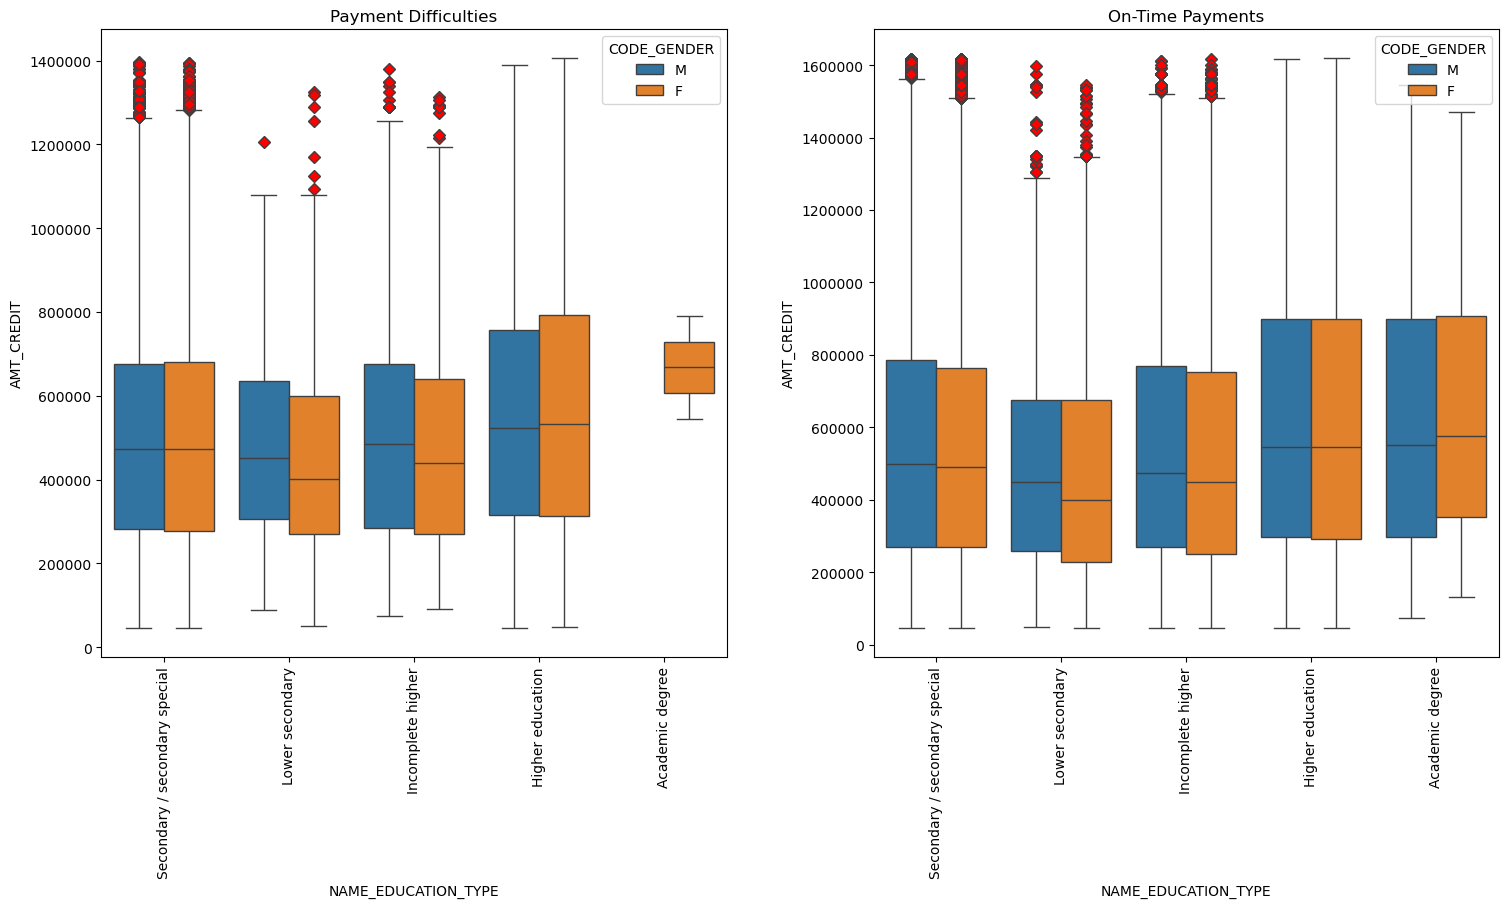

In [237]:
bi_boxplot('NAME_EDUCATION_TYPE','AMT_CREDIT',max_value1_AMT_CREDIT, max_value0_AMT_CREDIT, 'CODE_GENDER')

**Спостереження**
- Клієнти з "академічним ступенем" мають широкий діапазон кредитів для своєчасних платежів, тоді як для клієнтів з проблемами з оплатою цей діапазон значно нижчий
- Якщо поглянути на зведену статистику, то клієнти з "вищою освітою" та проблемами з оплатою беруть середній та медіанний кредит у значно більшому діапазоні, ніж клієнти з вчасною оплатою.
- Клієнти-чоловіки з "вищою освітою" завжди сплачують кредит вчасно

**Custom logic: 11** - create src logic for box plots

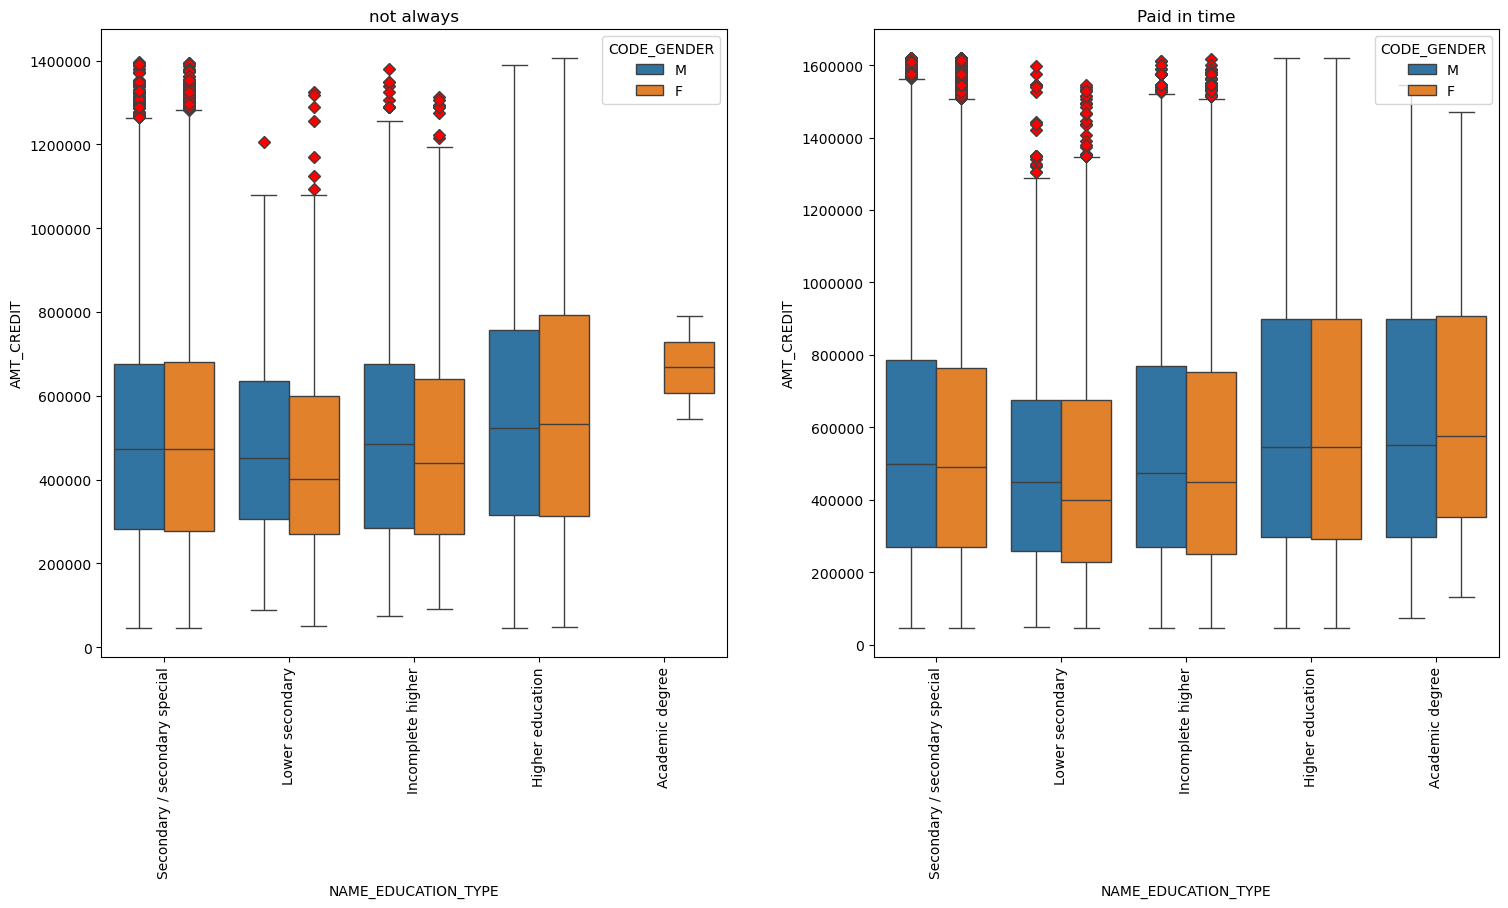

In [238]:
from mlpeople.visualization.categorical.boxplots import draw_bi_boxplot

draw_bi_boxplot(
    df,
    col_x='NAME_EDUCATION_TYPE', 
    col_y='AMT_CREDIT', 
    target_col='TARGET', 
    hue_col='CODE_GENDER', 
    drop_outliers=True,
    titles={
        0: 'Paid in time',
        1: 'not always'
    }
)

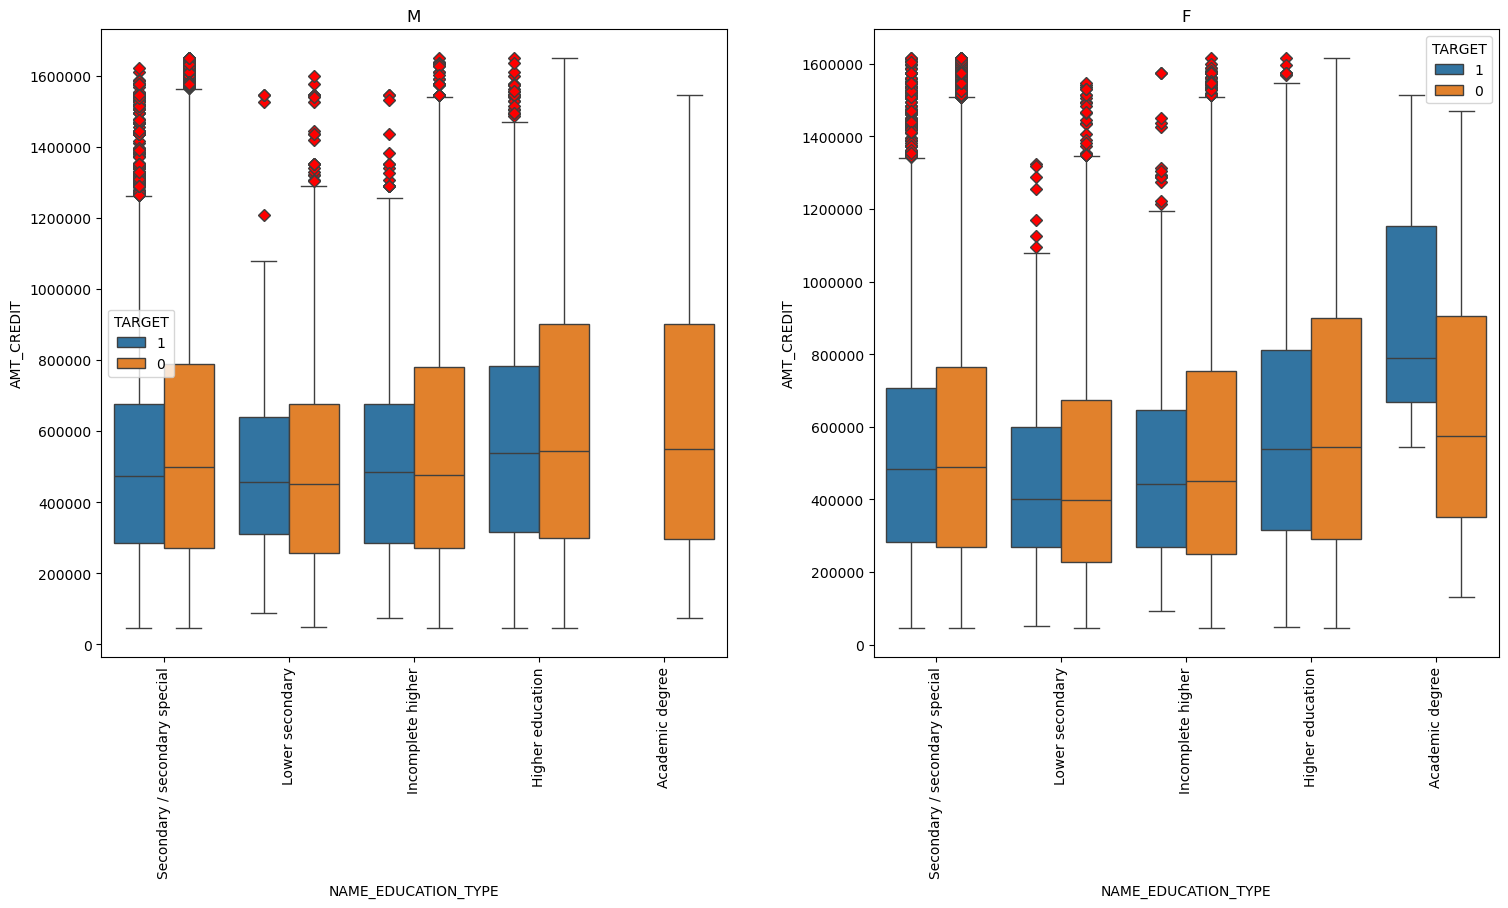

In [239]:
# flip gender and target
draw_bi_boxplot(
    df,
    col_x='NAME_EDUCATION_TYPE', 
    col_y='AMT_CREDIT', 
    target_col='CODE_GENDER', 
    hue_col='TARGET',
    drop_outliers=True,
    titles={
        0: 'Paid in time',
        1: 'not always'
    }
)

## Категоріальні та категоріальні змінні

### Аналіз стовпців `NAME_INCOME_TYPE` vs `CODE_GENDER`

In [ ]:
def bi_countplot_target(df0, df1, column, hue_column):
    group_name = f'Нормалізований розподіл значень за категорією: {column}'
    print(group_name.upper())

    pltname = 'Клієнт зі складнощями щодо платності'
    unique_hue_values = df1[hue_column].unique()
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches(14,4)

    proportions = df1.groupby(hue_column)[column].value_counts(normalize=True)
    proportions = (proportions*100).round(2)
    ax = proportions.unstack(hue_column).sort_values(
      by=unique_hue_values[0], ascending=False
      ).plot.bar(ax=axes[0], title=pltname)

    # анотація значень в барплоті
    for container in ax.containers:
      ax.bar_label(container, fmt='{:,.1f}%')

    pltname = 'Клієнти зі своєчасними платежами'
    unique_hue_values = df0[hue_column].unique()

    proportions = df0.groupby(hue_column)[column].value_counts (normalize=True)
    proportions = (proportions*100).round(2)
    ax = proportions.unstack(hue_column).sort_values(
    by=unique_hue_values[0], ascending=False
      ).plot.bar(ax=axes[1], title=pltname)

    for container in ax.containers:
      ax.bar_label(container, fmt='{:,.1f}%')

    plt.show()


    #------------
    group_name = f'Кількість значень за категорією {column}'
    print(group_name.upper())

    pltname = 'Клієнт зі своєчасними платежами'
    unique_hue_values = df1[hue_column].unique()
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches(14,4)
    counts = df1.groupby(hue_column)[column].value_counts()
    ax = counts.unstack(hue_column).sort_values(
      by=unique_hue_values [0], ascending=False
      ).plot.bar(ax=axes [0], title=pltname )

    for container in ax.containers:
      ax.bar_label(container)

    pltname = 'Клієнти зі своєчасними платежами'
    unique_hue_values = df0[hue_column].unique()
    counts = df0.groupby(hue_column)[column].value_counts()
    ax = counts.unstack(hue_column).sort_values (
      by=unique_hue_values[0], ascending=False
      ).plot.bar(ax=axes[1], title=pltname)

    for container in ax. containers:
      ax.bar_label(container)

    plt.show()

КЛІЄНТ ЗІ СКЛАДНОЩАМИ ЩОДО ПЛАТНОСТІ


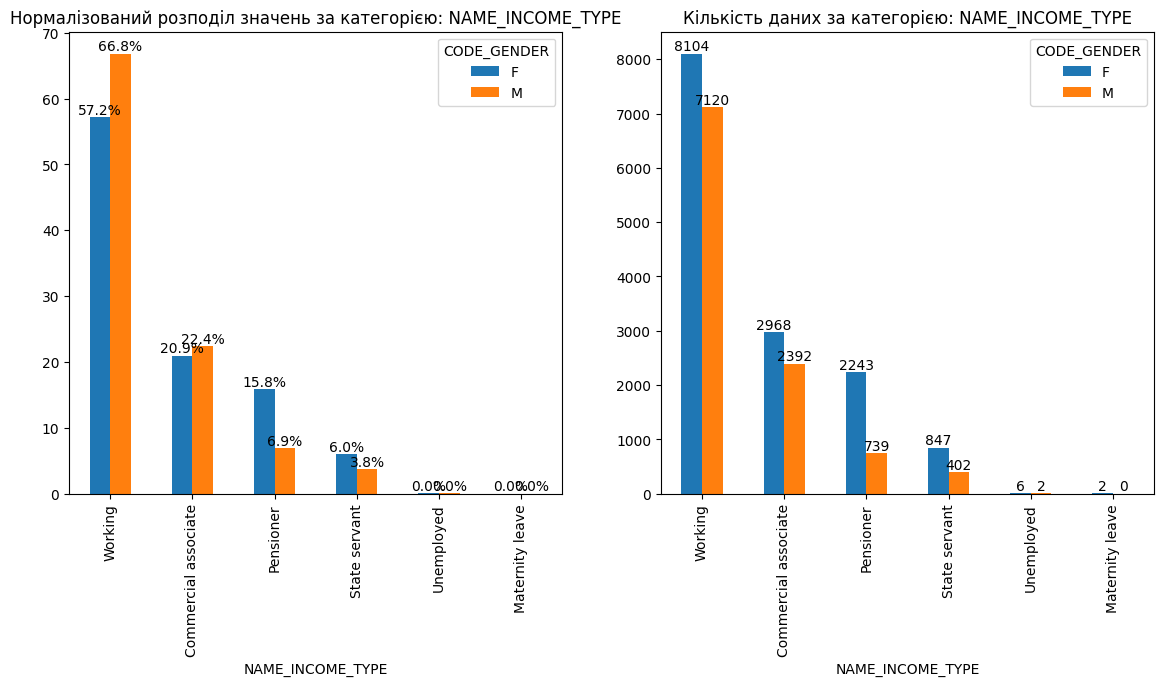

КЛІЄНТИ ЗІ СВОЄЧАСНИМИ ПЛАТЕЖАМИ


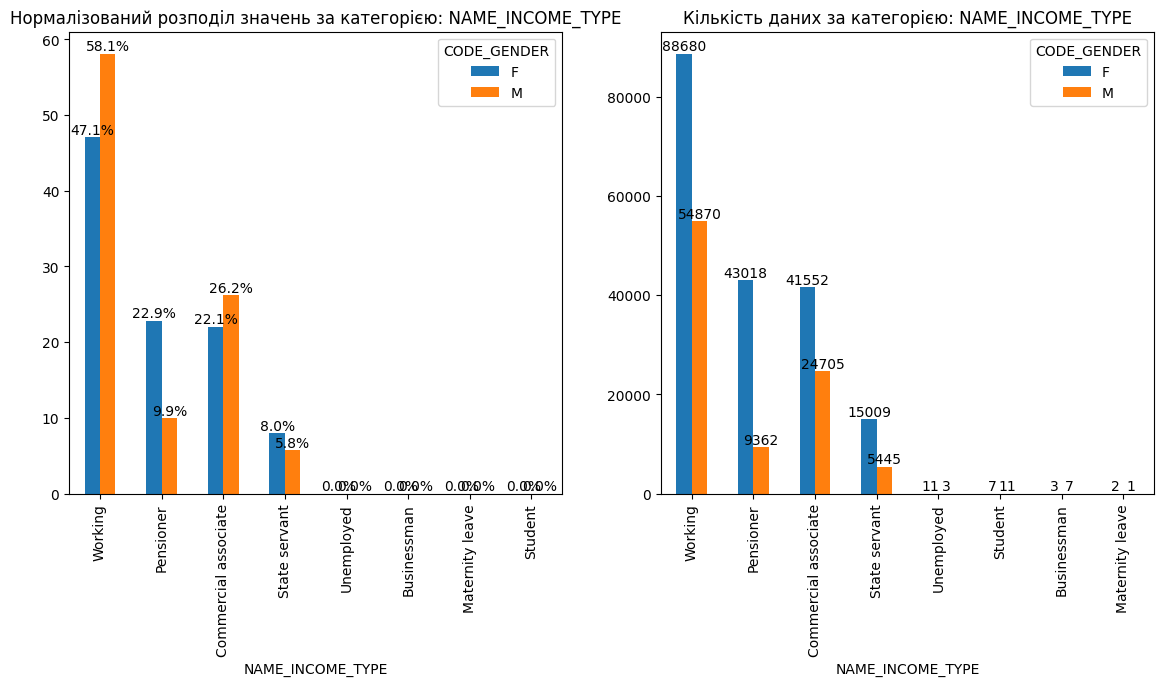

In [ ]:
bi_countplot_target(df0, df1, 'NAME_INCOME_TYPE','CODE_GENDER')

**Спостереження**
- Клієнти категорії `Working` та `Male` мають більше труднощів з оплатою порівняно з тими, хто платить вчасно
- Клієнти категорії `Pensioner` та `Female` мають більше труднощів з оплатою порівняно з тими, хто платить вчасно
- Клієнти категорії `Businessman` та `Student` здійснюють платежі вчасно, хоча їхня історія невелика

**Custom logic: 12** - create src logic for countplots plots

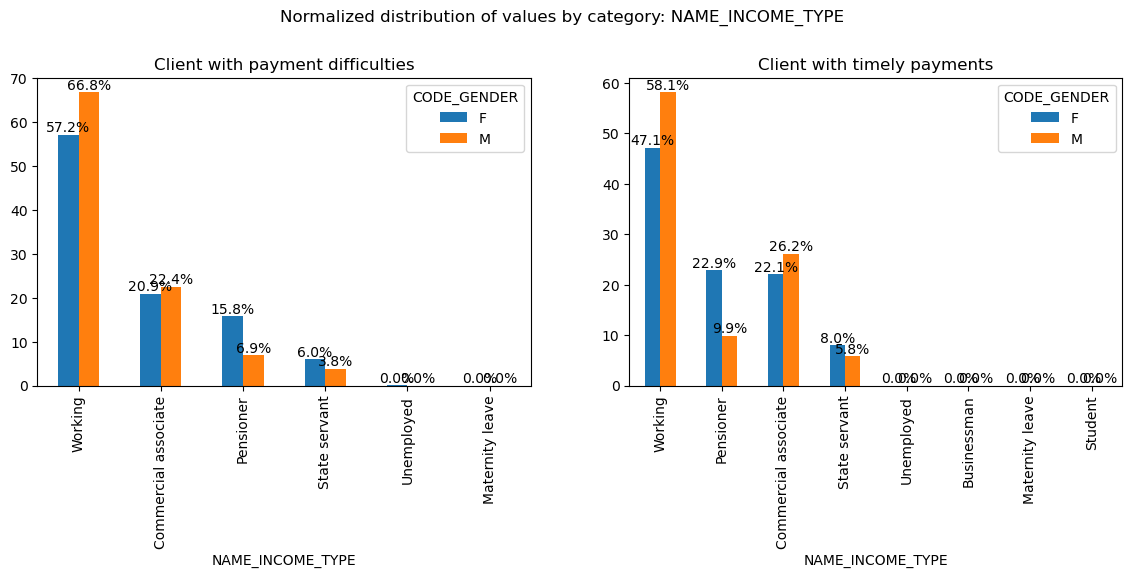

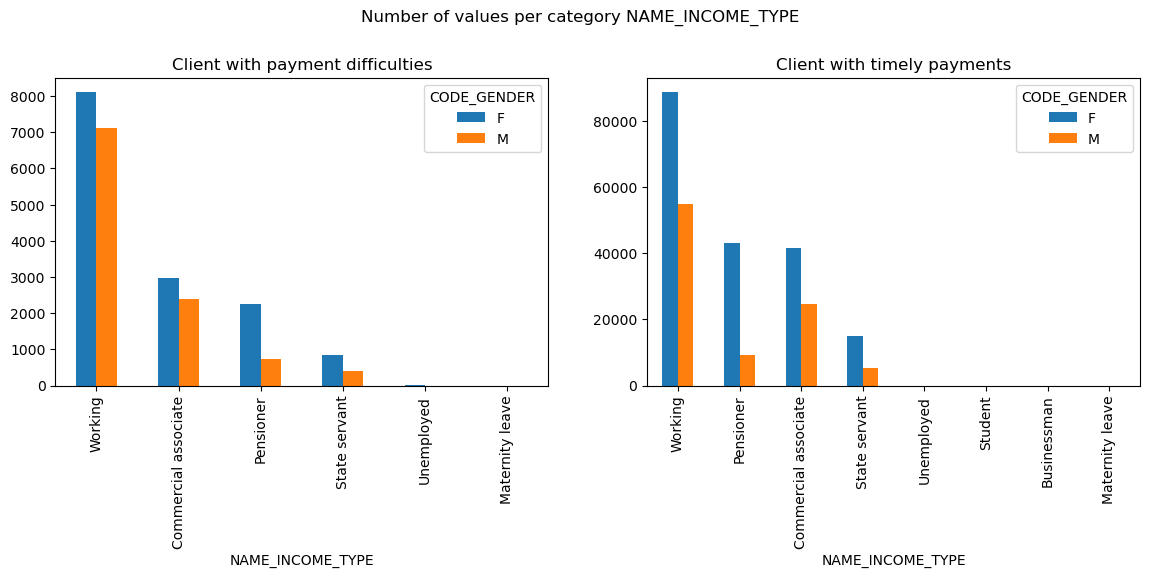

In [240]:
from mlpeople.visualization.categorical.countplots import draw_bi_countplot_target, draw_countplot

draw_bi_countplot_target(
    df, 'NAME_INCOME_TYPE', hue_col='CODE_GENDER',
    target_col='TARGET', normalize=True,
    titles={
        0: 'Client with timely payments',
        1: 'Client with payment difficulties'
    }
)

draw_bi_countplot_target(
    df, 'NAME_INCOME_TYPE', hue_col='CODE_GENDER',
    target_col='TARGET', normalize=False,
    titles={
        0: 'Client with timely payments',
        1: 'Client with payment difficulties'
    }
)

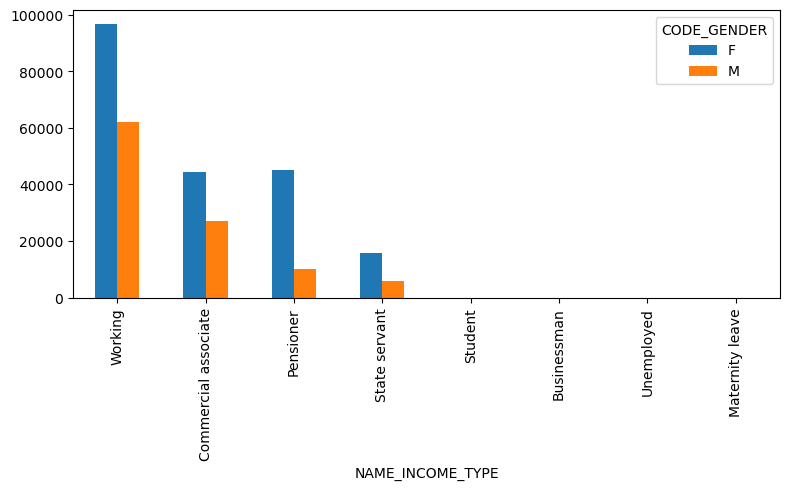

In [241]:
draw_countplot(df, 'NAME_INCOME_TYPE', hue_col='CODE_GENDER')

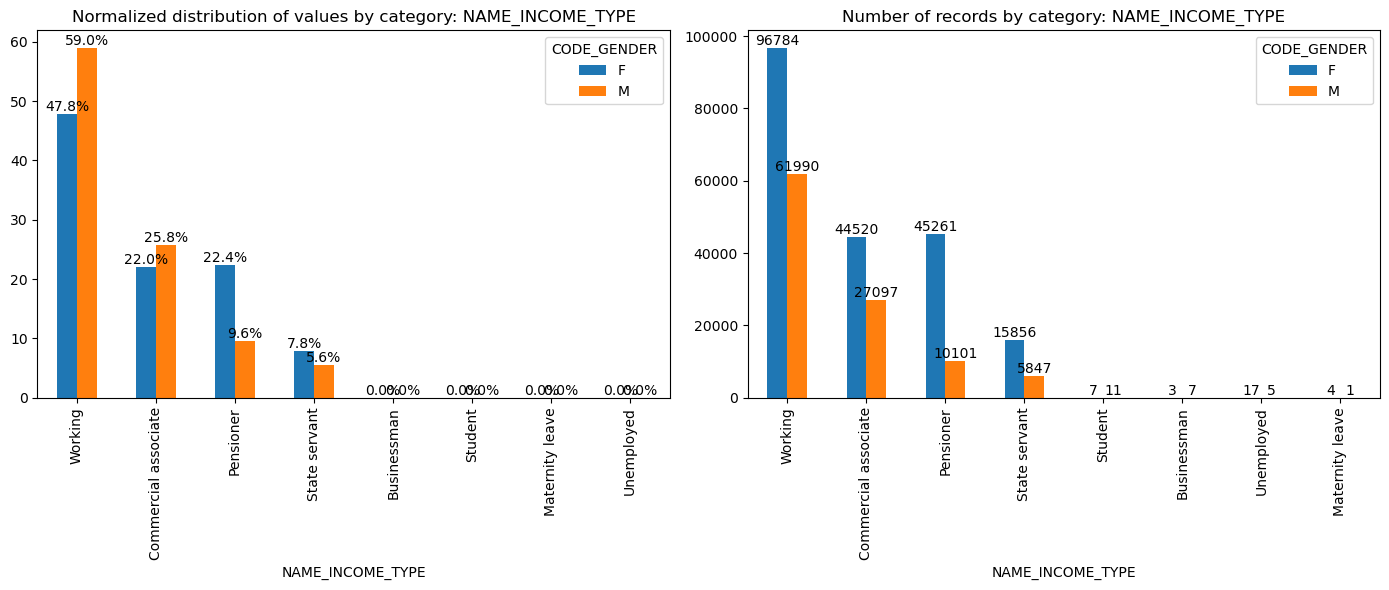

In [243]:
uni_cat_target_compare(df, 'NAME_INCOME_TYPE', hue_column='CODE_GENDER')